In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import re

---

# **Project Introduction**

## **Overview**
In today's competitive job market, indiscriminately applying to every available job posting is not only futile but also inefficient. A more strategic approach involves identifying job opportunities that align with an individual's specific skill set, thereby increasing the chances of the resume being shortlisted by Application Tracking Systems (ATS). This project aims to address this challenge by developing a recommender system that matches job seekers with the most relevant job postings based on their resumes.

## **Project Goals**
- **Objective**: To build a recommender system that informs job seekers of the best job opportunities aligned with their skills and experiences.
- **Target**: Enhance job application effectiveness by ensuring resumes are matched with suitable job postings, potentially increasing interview chances.

## **Current Status**
- **Progress**: We are on track with our initial goals and the project scope remains unchanged.
- **Insights**: The problem statement's open-ended nature has been acknowledged, leading to a structured plan for the upcoming phases of the project. Discussed at the end in up-coming work.

## **Notebook Content Overview**

### **Datasets**
The foundational dataset(s) for this project were sourced from Kaggle, featuring job listings scraped from LinkedIn across four major categories:
1. Data Analyst
2. Software Engineer
3. Data Scientist
4. Data Engineer

These categories encapsulate a substantial segment of the current Computer Science-related job market.

### **Methodology**

#### **Data Preparation**
- **Data Wrangling and Exploratory Data Analysis (EDA)**: Initial data cleaning and exploration to understand dataset characteristics.
- **Job Location Processing**: Deriving a 'city' column from 'job_location' to facilitate geocode retrieval.
- **Geocode Retrieval**: Implementing a caching mechanism for efficient batch retrieval of geocodes to avoid service provider blocks.

#### **Text Processing**
Comprehensive text processing on `job_description` and `job_skills`, including:
- Tokenization
- Case normalization
- Stopword removal
- Punctuation handling
- Lemmatization
- Part-of-Speech (POS) tagging
- Vectorization

#### **Modeling and Recommendations**
- Utilization of `CountVectorizer` and `Tf-Idf Vectorizer` for text vectorization.
- Matching job vectors to resume text to calculate similarity scores and identify top-n job recommendations.
- Application of K-Nearest Neighbors (KNN) for refined job recommendations.
- Visualization of recommended jobs in comparison to a baseline resume using t-SNE, highlighting the proximity of job opportunities in a reduced dimensional space.

Link: [Notebook in Repo](https://github.com/sauravjoshi/Career-Crafters/blob/main/Career_Crafters.ipynb)
[https://github.com/sauravjoshi/Career-Crafters/blob/main/Career_Crafters.ipynb](https://github.com/sauravjoshi/Career-Crafters/blob/main/Career_Crafters.ipynb)

Note: - If any visualization is not properly rendered in the exported pdf, please find all the visualizations at the end attached.

---


In [ ]:
df_analyst = pd.read_csv("./master/data_analyst.csv")
df_software = pd.read_csv("./master/software_engineering.csv")
df_scientist = pd.read_csv("./master/data_scientist.csv")
df_data = pd.read_csv("./master/data_engineer.csv")

In [ ]:
merged_dataframe = pd.concat([df_analyst, df_software, df_scientist, df_data], ignore_index=True)
merged_dataframe.to_csv("./merged_jobs.csv", index=False)

In [ ]:
df_master = pd.read_csv("./master/merged_jobs.csv")

Based on intial data exploration, following can be observed:
1. Presence of Null-values in job_summary and job_skills.
2. Presence of junk in job-description such as emoticons, symbols and invalid characters.
3. Over 32K rows of job postings.

In [ ]:
df_master.shape

(32641, 11)

In [ ]:
df_master.head()

job_title  \
0                      Data Analyst-SQL, Tableau   
1             Market Research & Insights Analyst   
2                    Business Systems Analyst `1   
3            Senior VAT and Indirect Tax Analyst   
4  Senior HRIS Analyst (Timekeeping and Payroll)   

                         company              job_location  \
0              Zortech Solutions         Mountain View, CA   
1  Indiana University Foundation           Bloomington, IN   
2                   Cook Medical           Bloomington, IN   
3                           Epic           Bloomington, IN   
4            Nordson Corporation  Greater Bloomington Area   

                                            job_link  first_seen  search_city  \
0    https://www.linkedin.com/jobs/data-analyst-jobs  2023-12-20  Bloomington   
1  https://www.linkedin.com/jobs/view/market-rese...  2023-12-20  Bloomington   
2  https://www.linkedin.com/jobs/view/business-sy...  2023-12-20  Bloomington   
3  https://www.linkedin.com/jobs/view/senior-vat-...  2023-12-20  Bloomington   
4  https://www.linkedin.com/jobs/view/senior-hris...  2023-12-20  Bloomington   

  search_country   job level job_type  \
0  United States   Associate   Onsite   
1  United States  Mid senior   Onsite   
2  United States  Mid senior   Onsite   
3  United States  Mid senior   Onsite   
4  United States  Mid senior   Remote   

                                         job_summary  \
0                                                NaN   
1  Company Description\nAre you a high-performer ...   
2  Overview\nThe Business Systems Analyst 1 perfo...   
3  We're looking for an experienced tax professio...   
4  Collaboration drives Nordson’s success as a ma...   

                                          job_skills  
0                                                NaN  
1  Data analysis, Market research, Survey develop...  
2  Business Analysis, Technical Writing, Software...  
3  Accounting, Finance, VAT/GST tax regimes, US a...  
4  Workday HCM, UKG Dimensions, Ceridian Dayforce...

In [ ]:
df_master.describe()

job_title            company   job_location  \
count                      32641              32641          32641   
unique                     13465               9150           3259   
top     Senior Software Engineer  Jobs for Humanity  United States   
freq                         794                805            598   

                                                 job_link  first_seen  \
count                                               32641       32641   
unique                                              29331           3   
top     https://ca.linkedin.com/jobs/view/customer-ser...  2023-12-20   
freq                                                    3       17236   

           search_city search_country   job level job_type  \
count            32641          32641       32641    32641   
unique             960              7           2        3   
top     Greater London  United States  Mid senior   Onsite   
freq               341          25283       26244    15707   

                                              job_summary  \
count                                               32230   
unique                                              24147   
top     Who is Recruiting from Scratch :\nRecruiting f...   
freq                                                  136   

                                               job_skills  
count                                               31368  
unique                                              31244  
top     Databricks, SQL, Python, PySpark, Azure Data F...  
freq                                                    7


> Since job_skills and job_summary are most important features for modelling, removing those with no information.
> Also fixing the job_countries text irregularities.



In [ ]:
df_master.isna().sum()

job_title            0
company              0
job_location         0
job_link             0
first_seen           0
search_city          0
search_country       0
job level            0
job_type             0
job_summary        411
job_skills        1273
dtype: int64

In [ ]:
df_master.dropna(inplace=True)

In [ ]:
df_master.isna().sum()

job_title         0
company           0
job_location      0
job_link          0
first_seen        0
search_city       0
search_country    0
job level         0
job_type          0
job_summary       0
job_skills        0
dtype: int64

In [ ]:
df_master.shape

(31368, 11)

In [ ]:
df_master["search_country"].value_counts()

United States      24434
United Kingdom      2732
Canada              1779
Australia            810
 Canada              767
 United Kingdom      617
 Australia           229
Name: search_country, dtype: int64

In [ ]:
df_master['search_country'] = df_master['search_country'].str.strip()

In [ ]:
df_master["search_country"].value_counts()

United States     24434
United Kingdom     3349
Canada             2546
Australia          1039
Name: search_country, dtype: int64

In [ ]:
df_master["job_title"].value_counts()

Senior Software Engineer                                      793
Software Engineer                                             587
Data Analyst                                                  572
Senior Data Engineer                                          531
Data Engineer                                                 472
                                                             ... 
Senior Business Systems Analyst, Finance Systems                1
Senior FMV Analyst                                              1
BCBA - Board Certified Behavior Analyst                         1
Treasury Analyst Senior                                         1
Installation Supervisor Data Cables / International Travel      1
Name: job_title, Length: 13155, dtype: int64

In [ ]:
unique_list = []

for col in df_master.columns:
    item = (col, df_master[col].nunique(), df_master[col].dtypes, df_master[col].unique())
    unique_list.append(item)

unique_counts = pd.DataFrame(
    unique_list,
    columns=["Column", "Number_of_unique_values", "Type", "Unique_category"]
).sort_values(by="Number_of_unique_values")


display(unique_counts)

*The first_seen column serves no value for us. Removing it.*

In [ ]:
df_master.drop('first_seen', axis=1, inplace=True)


In [ ]:
df_copy = df_master.copy()

In [ ]:
df_master = df_copy

This section does the following:
1. Tries to extract city from the job_location.
2. For cities marked as unknown as result of (1), information is tried to extract via a custom script defined in cells below.

In [ ]:
from geotext import GeoText

def extract_city_with_geotext(location):
    places = GeoText(location)
    cities = list(places.cities)
    return cities[0] if cities else 'Unknown'

df_master['city'] = df_master['job_location'].apply(extract_city_with_geotext)

In [ ]:
df_master.head()

job_title  \
1             Market Research & Insights Analyst   
2                    Business Systems Analyst `1   
3            Senior VAT and Indirect Tax Analyst   
4  Senior HRIS Analyst (Timekeeping and Payroll)   
5      Business Intelligence Reporting Analyst 2   

                         company              job_location  \
1  Indiana University Foundation           Bloomington, IN   
2                   Cook Medical           Bloomington, IN   
3                           Epic           Bloomington, IN   
4            Nordson Corporation  Greater Bloomington Area   
5                   Cook Medical           Bloomington, IN   

                                            job_link  search_city  \
1  https://www.linkedin.com/jobs/view/market-rese...  Bloomington   
2  https://www.linkedin.com/jobs/view/business-sy...  Bloomington   
3  https://www.linkedin.com/jobs/view/senior-vat-...  Bloomington   
4  https://www.linkedin.com/jobs/view/senior-hris...  Bloomington   
5  https://www.linkedin.com/jobs/view/business-in...  Bloomington   

  search_country   job level job_type  \
1  United States  Mid senior   Onsite   
2  United States  Mid senior   Onsite   
3  United States  Mid senior   Onsite   
4  United States  Mid senior   Remote   
5  United States  Mid senior   Hybrid   

                                         job_summary  \
1  Company Description\nAre you a high-performer ...   
2  Overview\nThe Business Systems Analyst 1 perfo...   
3  We're looking for an experienced tax professio...   
4  Collaboration drives Nordson’s success as a ma...   
5  Overview\nThe Business Intelligence Analyst 2 ...   

                                          job_skills         city  
1  Data analysis, Market research, Survey develop...  Bloomington  
2  Business Analysis, Technical Writing, Software...  Bloomington  
3  Accounting, Finance, VAT/GST tax regimes, US a...  Bloomington  
4  Workday HCM, UKG Dimensions, Ceridian Dayforce...      Unknown  
5  SAP Business Objects, SQL, Qlik, Data Modeling...  Bloomington

In [ ]:
unknown_city_rows = df_master[df_master['city'] == 'Unknown']
unknown_city_rows.count()

job_title         5847
company           5847
job_location      5847
job_link          5847
search_city       5847
search_country    5847
job level         5847
job_type          5847
job_summary       5847
job_skills        5847
city              5847
dtype: int64

In [ ]:
known_countries = ['United States', 'Australia', 'Canada']
known_regions = ['England', 'Scotland', 'Wales', 'Northern Ireland']

known_states_us = [
    'AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA',
    'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD',
    'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ',
    'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC',
    'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY'
]

def refine_city_extraction(row):

    if row['city'] == 'Unknown':
        location = row['job_location']
        parts = [part.strip() for part in location.split(',')]
        if len(parts) == 2 and parts[1] in known_states_us:
            return parts[0]
        elif len(parts) == 3:
            return parts[0]

    return row['city']

df_master['city'] = df_master.apply(refine_city_extraction, axis=1)

print(df_master[['job_location', 'city']])

                                    job_location              city
1                                Bloomington, IN       Bloomington
2                                Bloomington, IN       Bloomington
3                                Bloomington, IN       Bloomington
4                       Greater Bloomington Area           Unknown
5                                Bloomington, IN       Bloomington
...                                          ...               ...
32635  Northamptonshire, England, United Kingdom  Northamptonshire
32636          Brackley, England, United Kingdom          Brackley
32637       Northampton, England, United Kingdom       Northampton
32638     Milton Keynes, England, United Kingdom     Milton Keynes
32639            Manchester Area, United Kingdom           Unknown

[31368 rows x 2 columns]


1.   Even after processing the cities, the left-over rows are dropped.
2.   Number of unknown cities went from 5847 to 2217



In [ ]:
unknown_city_count = df_master[df_master['city'] == 'Unknown']["job_location"].count()
print(f"Number of rows with 'Unknown' city: {unknown_city_count}")


df_master = df_master[df_master['city'] != 'Unknown']
df_master.reset_index(drop=True, inplace=True)

df_master.head()

Number of rows with 'Unknown' city: 2217


job_title                        company  \
0         Market Research & Insights Analyst  Indiana University Foundation   
1                Business Systems Analyst `1                   Cook Medical   
2        Senior VAT and Indirect Tax Analyst                           Epic   
3  Business Intelligence Reporting Analyst 2                   Cook Medical   
4               Lead Senior Business Analyst         Nashville Toyota North   

       job_location                                           job_link  \
0   Bloomington, IN  https://www.linkedin.com/jobs/view/market-rese...   
1   Bloomington, IN  https://www.linkedin.com/jobs/view/business-sy...   
2   Bloomington, IN  https://www.linkedin.com/jobs/view/senior-vat-...   
3   Bloomington, IN  https://www.linkedin.com/jobs/view/business-in...   
4  Laughlin AFB, TX  https://www.linkedin.com/jobs/view/lead-senior...   

   search_city search_country   job level job_type  \
0  Bloomington  United States  Mid senior   Onsite   
1  Bloomington  United States  Mid senior   Onsite   
2  Bloomington  United States  Mid senior   Onsite   
3  Bloomington  United States  Mid senior   Hybrid   
4      Del Rio  United States  Mid senior   Hybrid   

                                         job_summary  \
0  Company Description\nAre you a high-performer ...   
1  Overview\nThe Business Systems Analyst 1 perfo...   
2  We're looking for an experienced tax professio...   
3  Overview\nThe Business Intelligence Analyst 2 ...   
4  R2C, Inc. is a rapidly growing, SDVOSB headqua...   

                                          job_skills          city  
0  Data analysis, Market research, Survey develop...   Bloomington  
1  Business Analysis, Technical Writing, Software...   Bloomington  
2  Accounting, Finance, VAT/GST tax regimes, US a...   Bloomington  
3  SAP Business Objects, SQL, Qlik, Data Modeling...   Bloomington  
4  Information technology, Microsoft Office, Data...  Laughlin AFB



1.   Next we try to get the geocode of the cities.
2.   Seeing the number of unique cities as 2569, it was better to cache the geocodes, to avoid repeated request for same city from API.



In [ ]:
df_master["city"].nunique()

2569

In [ ]:
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut, GeocoderUnavailable
from time import sleep

In [ ]:
l = geolocator.geocode("Monrovia, CA")

In [ ]:
len(geocode_cache)

1701

In [ ]:
geolocator = Nominatim(user_agent="sauravjoshi_33@rediffmail.com")

# Cache for storing city geocodes to avoid repeated requests
geocode_cache = {}

In [ ]:

def get_lat_lon(city):
    if city in geocode_cache:
        return geocode_cache[city]
    else:
        max_retries = 5
        retries = 0
        while retries < max_retries:
            try:
                location = geolocator.geocode(city)
                if location:
                    geocode_cache[city] = (location.latitude, location.longitude)
                    print(f"Found: {geocode_cache[city]}")
                    return geocode_cache[city]
                else:
                    print(f"Not found: {city}")
                    geocode_cache[city] = (None, None)
                    return (None, None)
            except (GeocoderTimedOut, GeocoderUnavailable):
                retries += 1
                sleep_time = 5
                print(f"Timeout or unavailable, retrying... ({retries}/{max_retries})")
                sleep(sleep_time)
        return (None, None)

def process_batch(cities):
    return cities.apply(get_lat_lon)

# Batch processing
batch_size = 1000
for start in range(0, len(df_master), batch_size):
    end = start + batch_size
    df_master.loc[start:end, 'latitude_longitude'] = process_batch(df_master['job_location'][start:end])
    print(f"Processed batch {start//batch_size + 1}/{(len(df_master) - 1)//batch_size + 1}")
    sleep(1)

print(df_master.head())


In [ ]:
none_count = df_master['latitude_longitude'].apply(lambda x: x == (None, None)).sum()
print(f"Number of (None, None) entries: {none_count}")
print(df_master.shape)

Number of (None, None) entries: 397
(29147, 14)


In [ ]:
df_master = df_processed_coordinates.copy()

In [ ]:
df_processed_coordinates = df_master.copy()
df_master = df_master[df_master['latitude_longitude'] != (None, None)]
df_master.reset_index(drop=True, inplace=True)
print(df_master.shape)

(28750, 14)


In [ ]:
df_master.to_csv('./sample_data/coordinates_processed_merged.csv', index=False)

In [ ]:
df_master = pd.read_csv("./drive/MyDrive/418/coordinates_processed_merged.csv")

In [ ]:
df_master.head(2)

job_title                        company  \
0  Market Research & Insights Analyst  Indiana University Foundation   
1         Business Systems Analyst `1                   Cook Medical   

      job_location                                           job_link  \
0  Bloomington, IN  https://www.linkedin.com/jobs/view/market-rese...   
1  Bloomington, IN  https://www.linkedin.com/jobs/view/business-sy...   

   search_city search_country   job level job_type  \
0  Bloomington  United States  Mid senior   Onsite   
1  Bloomington  United States  Mid senior   Onsite   

                                         job_summary  \
0  Company Description\nAre you a high-performer ...   
1  Overview\nThe Business Systems Analyst 1 perfo...   

                                          job_skills         city  \
0  Data analysis, Market research, Survey develop...  Bloomington   
1  Business Analysis, Technical Writing, Software...  Bloomington   

          latitude_longitude  latitude  longitude  
0  (39.1670396, -86.5342881)  39.16704 -86.534288  
1  (39.1670396, -86.5342881)  39.16704 -86.534288


**Now as we have latitude_longitude, we try to extract some information out of the jobs posted.**

In [ ]:
import folium
from folium.plugins import HeatMap

In [ ]:
# df_master = df_processed_coordinates.copy()

In [ ]:
df_processed_coordinates = df_master.copy()

In [ ]:
df_master.head()

job_title                        company  \
0         Market Research & Insights Analyst  Indiana University Foundation   
1                Business Systems Analyst `1                   Cook Medical   
2        Senior VAT and Indirect Tax Analyst                           Epic   
3  Business Intelligence Reporting Analyst 2                   Cook Medical   
4               Lead Senior Business Analyst         Nashville Toyota North   

       job_location                                           job_link  \
0   Bloomington, IN  https://www.linkedin.com/jobs/view/market-rese...   
1   Bloomington, IN  https://www.linkedin.com/jobs/view/business-sy...   
2   Bloomington, IN  https://www.linkedin.com/jobs/view/senior-vat-...   
3   Bloomington, IN  https://www.linkedin.com/jobs/view/business-in...   
4  Laughlin AFB, TX  https://www.linkedin.com/jobs/view/lead-senior...   

   search_city search_country   job level job_type  \
0  Bloomington  United States  Mid senior   Onsite   
1  Bloomington  United States  Mid senior   Onsite   
2  Bloomington  United States  Mid senior   Onsite   
3  Bloomington  United States  Mid senior   Hybrid   
4      Del Rio  United States  Mid senior   Hybrid   

                                         job_summary  \
0  Company Description\nAre you a high-performer ...   
1  Overview\nThe Business Systems Analyst 1 perfo...   
2  We're looking for an experienced tax professio...   
3  Overview\nThe Business Intelligence Analyst 2 ...   
4  R2C, Inc. is a rapidly growing, SDVOSB headqua...   

                                          job_skills          city  \
0  Data analysis, Market research, Survey develop...   Bloomington   
1  Business Analysis, Technical Writing, Software...   Bloomington   
2  Accounting, Finance, VAT/GST tax regimes, US a...   Bloomington   
3  SAP Business Objects, SQL, Qlik, Data Modeling...   Bloomington   
4  Information technology, Microsoft Office, Data...  Laughlin AFB   

          latitude_longitude   latitude   longitude  
0  (39.1670396, -86.5342881)  39.167040  -86.534288  
1  (39.1670396, -86.5342881)  39.167040  -86.534288  
2  (39.1670396, -86.5342881)  39.167040  -86.534288  
3  (39.1670396, -86.5342881)  39.167040  -86.534288  
4  (29.3614054, -100.778572)  29.361405 -100.778572

In [ ]:
df_master["latitude"][0]

39.1670396

**Visualization 1: Saurav Joshi**

1.   This heatmap shows us the job locations which are present across different countries.
2.   The jobs seems to be more concentrated over West & Mid-West of America than Easts, Almost entirety in Ausralia towards the East-coast, mostly in London, Manchester and Birmingham in UK and interestingly almost every job in Canada, comes with a location at a closer proximity with US such as at Vancouver and Montreal.
3.   This visualization in-turn gives rise to know what jobs are prevalent in which regions.



In [ ]:
coords = df_master[['latitude', 'longitude']].values.tolist()
map_center = [df_master['latitude'].mean(), df_master['longitude'].mean()]
m2 = folium.Map(location=map_center, zoom_start=2)
HeatMap(coords).add_to(m2)

In [ ]:
m2

In [ ]:
# HeatMap(coords).add_to(m)
map_file_path = './drive/MyDrive/418/heatmap.html'
m2.save(map_file_path)

map_file_path

'./drive/MyDrive/418/heatmap.html'

In [ ]:
import pandas as pd
import plotly.express as px

fig = px.scatter_geo(df_master,
                     lat='latitude',
                     lon='longitude',
                     title='Geographical Plot of Cities')

fig.update_layout(showlegend=True, geo=dict(
    landcolor='rgb(217, 217, 217)',
))

fig.show()


**Some more supportive visualizations for knowning the split of data on job_types and the countries they were searched from.**

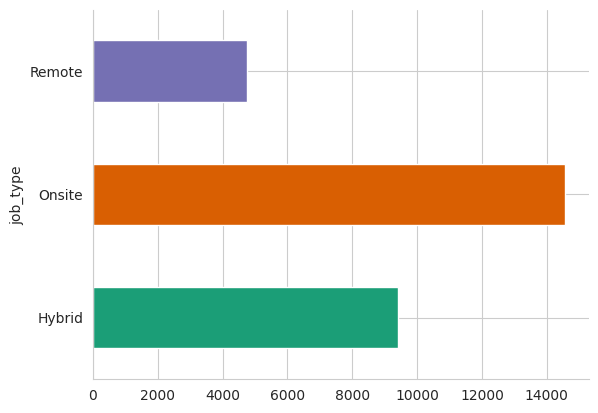

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
df_master.groupby('job_type').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

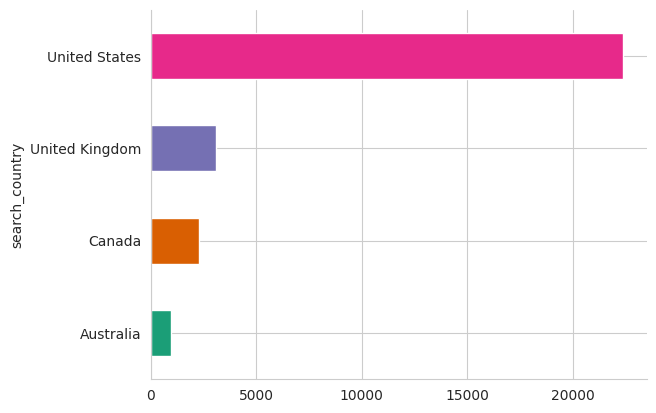

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
df_master.groupby('search_country').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
df_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28750 entries, 0 to 28749
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   job_title           28750 non-null  object 
 1   company             28750 non-null  object 
 2   job_location        28750 non-null  object 
 3   job_link            28750 non-null  object 
 4   search_city         28750 non-null  object 
 5   search_country      28750 non-null  object 
 6   job level           28750 non-null  object 
 7   job_type            28750 non-null  object 
 8   job_summary         28750 non-null  object 
 9   job_skills          28750 non-null  object 
 10  city                28750 non-null  object 
 11  latitude_longitude  28750 non-null  object 
 12  latitude            28750 non-null  float64
 13  longitude           28750 non-null  float64
dtypes: float64(2), object(12)
memory usage: 3.1+ MB


**To get more information on job titles the irregularities present in the values of job_titles need to be handled.**

In [ ]:
df_master['job_title'].value_counts().head(25)
# It can be seen that there are repetitions present like Senior Software Engineer and Sr. Software Engineer
# Also Senior Data Analyst vs Sr. Data Analyst.
# Such titles need to be handled and changed into a single category.
# Not only these, some job title come along with name of company or some additional metadata which creates them as a new category.

Senior Software Engineer                                        735
Software Engineer                                               513
Data Analyst                                                    471
Senior Data Engineer                                            463
Business Analyst                                                415
Data Engineer                                                   400
Senior Data Analyst                                             313
Data Scientist                                                  304
Senior Financial Analyst                                        256
Senior Data Scientist                                           238
Senior Staff AI Data Engineer                                   235
Business Systems Analyst                                        192
Software Developer                                              162
Senior Software Developer                                       142
Business Intelligence Analyst                   

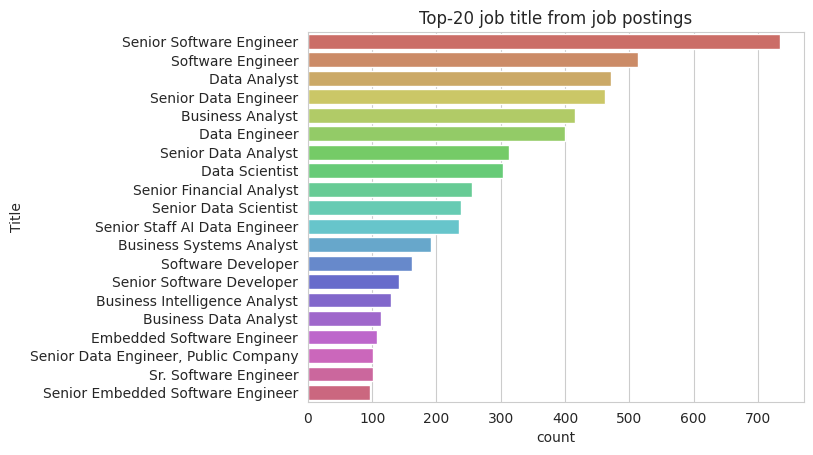

In [ ]:
job_title = df_master["job_title"].value_counts().reset_index()[:20]
job_title.columns = ["Title", "count"]

sns.barplot(x="count", y="Title", data=job_title, color="blue", palette="hls").set(title="Top-20 job title from job postings");



> Resolving Cases such as:
> 1. Resolve Sr. Data Engineer to Senior Data Engineer
> 2. Sr. Data Analyst to Senior Data Analyst
> 3. Or Data Engineer - Scala(U.S. remote) to Data Engineer
> 4. Senior Data Engineer, Public Company to Senior Data Engineer
> 5. Labs - Data Scientist - Senior Associate to Data Scientist
> 6. Data Analyst (Bangkok Based, relocation provided) to Data Analyst



In [ ]:
import re

def normalize_job_title(title):

    title = title.replace('Sr.', 'Senior')
    title = re.sub(r'\bSDE\b', 'Software Development Engineer', title, flags=re.IGNORECASE)
    title = re.sub(r'\bSW Engineer\b', 'Software Engineer', title, flags=re.IGNORECASE)

    title = re.sub(r'\s*-\s*.*', '', title)
    title = re.sub(r'\s*,\s*.*', '', title)
    title = re.sub(r'\(.*\)', '', title)

    title = title.strip()
    title = re.sub(r'[^A-Za-z0-9\s\-,.]', '', title)

    return title

df_master['normalized_job_title'] = df_master['job_title'].apply(normalize_job_title)


print(df_master[['job_title', 'normalized_job_title']])

                                               job_title  \
0                     Market Research & Insights Analyst   
1                            Business Systems Analyst `1   
2                    Senior VAT and Indirect Tax Analyst   
3              Business Intelligence Reporting Analyst 2   
4                           Lead Senior Business Analyst   
...                                                  ...   
28745  Customer Service Representative/Data Analyst/D...   
28746                        HR Systems and Data Analyst   
28747                         Senior Oracle Data Analyst   
28748                            Data Governance Analyst   
28749                   Energy Data and Forecast Analyst   

                                    normalized_job_title  
0                      Market Research  Insights Analyst  
1                             Business Systems Analyst 1  
2                    Senior VAT and Indirect Tax Analyst  
3              Business Intelligence Report

In [ ]:
df_master['normalized_job_title'].value_counts().head(25)

Senior Software Engineer             2111
Software Engineer                    1155
Senior Data Engineer                  852
Data Analyst                          704
Data Engineer                         653
Business Analyst                      627
Senior Data Analyst                   549
Data Scientist                        482
Senior Data Scientist                 461
Senior Financial Analyst              389
Senior Analyst                        313
Software Developer                    294
Business Systems Analyst              294
Lead Software Engineer                262
Senior Software Developer             238
Senior Staff AI Data Engineer         236
Staff Software Engineer               193
Business Intelligence Analyst         158
Senior Embedded Software Engineer     143
Business Data Analyst                 142
Senior Business Analyst               128
Data Center Engineer                  128
Embedded Software Engineer            125
Principal Software Engineer       

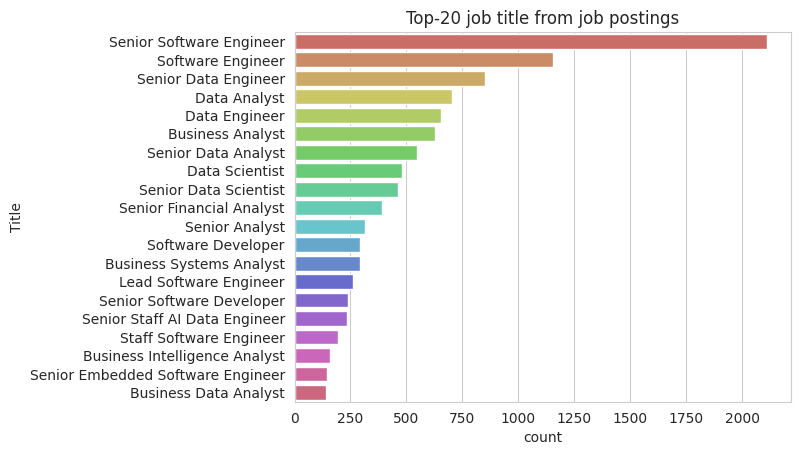

In [ ]:
job_title = df_master["normalized_job_title"].value_counts().reset_index()[:20]
job_title.columns = ["Title", "count"]

sns.barplot(x="count", y="Title", data=job_title, color="blue", palette="hls").set(title="Top-20 job title from job postings");

In [ ]:
df_master.head()

job_title                        company  \
0         Market Research & Insights Analyst  Indiana University Foundation   
1                Business Systems Analyst `1                   Cook Medical   
2        Senior VAT and Indirect Tax Analyst                           Epic   
3  Business Intelligence Reporting Analyst 2                   Cook Medical   
4               Lead Senior Business Analyst         Nashville Toyota North   

       job_location                                           job_link  \
0   Bloomington, IN  https://www.linkedin.com/jobs/view/market-rese...   
1   Bloomington, IN  https://www.linkedin.com/jobs/view/business-sy...   
2   Bloomington, IN  https://www.linkedin.com/jobs/view/senior-vat-...   
3   Bloomington, IN  https://www.linkedin.com/jobs/view/business-in...   
4  Laughlin AFB, TX  https://www.linkedin.com/jobs/view/lead-senior...   

   search_city search_country   job level job_type  \
0  Bloomington  United States  Mid senior   Onsite   
1  Bloomington  United States  Mid senior   Onsite   
2  Bloomington  United States  Mid senior   Onsite   
3  Bloomington  United States  Mid senior   Hybrid   
4      Del Rio  United States  Mid senior   Hybrid   

                                         job_summary  \
0  Company Description\nAre you a high-performer ...   
1  Overview\nThe Business Systems Analyst 1 perfo...   
2  We're looking for an experienced tax professio...   
3  Overview\nThe Business Intelligence Analyst 2 ...   
4  R2C, Inc. is a rapidly growing, SDVOSB headqua...   

                                          job_skills          city  \
0  Data analysis, Market research, Survey develop...   Bloomington   
1  Business Analysis, Technical Writing, Software...   Bloomington   
2  Accounting, Finance, VAT/GST tax regimes, US a...   Bloomington   
3  SAP Business Objects, SQL, Qlik, Data Modeling...   Bloomington   
4  Information technology, Microsoft Office, Data...  Laughlin AFB   

          latitude_longitude   latitude   longitude  \
0  (39.1670396, -86.5342881)  39.167040  -86.534288   
1  (39.1670396, -86.5342881)  39.167040  -86.534288   
2  (39.1670396, -86.5342881)  39.167040  -86.534288   
3  (39.1670396, -86.5342881)  39.167040  -86.534288   
4  (29.3614054, -100.778572)  29.361405 -100.778572   

                        normalized_job_title  
0          Market Research  Insights Analyst  
1                 Business Systems Analyst 1  
2        Senior VAT and Indirect Tax Analyst  
3  Business Intelligence Reporting Analyst 2  
4               Lead Senior Business Analyst

In [ ]:
df_2 = df_master.copy()
# df_master = df_2.copy()

**Visualization 2: Saurav Joshi**


> Now since we have normalized_job_title, we can now investigate dominant jobs based on cities.
- The concentration of points illustrates the relative number of jobs in each region, giving a visual representation of job availability and market demand.
- The clusters of job points may correlate with economic centers and tech hubs, suggesting where certain industries are thriving.
- This can allow candidates to target specific cities which are having more job postings as per their required job title.




In [ ]:
dominant_jobs = df_master.groupby('latitude_longitude')['normalized_job_title'].agg(
    lambda x: x.value_counts().idxmax()).reset_index(name='dominant_job')

In [ ]:
dominant_jobs.head()

latitude_longitude  \
0                 (-11.9547401, -77.0612044)   
1                 (-11.9862556, -77.0096138)   
2                 (-12.1106354, -77.0471789)   
3                   (-12.46044, 130.8410469)   
4  (-12.463508000000001, 130.84355545363502)   

                                dominant_job  
0                          eCommerce Analyst  
1                       Senior Data Engineer  
2              Business Intelligence Analyst  
3                         Gi3 Senior Analyst  
4  Business Analyst for a Period of 6 Months

In [ ]:
df_master = pd.merge(df_master, dominant_jobs, on='latitude_longitude', how='left')
fig = px.scatter_mapbox(df_master,
                        lat="latitude",
                        lon="longitude",
                        hover_name="dominant_job",
                        zoom=1,
                        height=600,
                        mapbox_style="carto-positron")

fig.show()

In [ ]:
# Next thing to do is Text-preprocessing. Primarily for Job description and Normalized job title column.
# - tokenization
# - case handling, stop word removal
# - punctutation handling
# - lemmatization
# - POS tagging
# - Vectorization

import nltk
nltk.download("stopwords")
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('wordnet')
from nltk import word_tokenize, pos_tag, pos_tag_sents
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from string import punctuation
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
def text_preprocessing(data_master):

    data_master["job_skills_summary"] = data_master["job_skills_summary"].apply(lambda x: re.sub( r"([A-Z][^a-z]*)", r" \1", x))
    data_master["job_skills_summary"] = data_master["job_skills_summary"].str.lower()

    return data_master

def get_pos(data_master):

    texts = data_master["job_skills_summary"].tolist()
    tagged_texts = pos_tag_sents(map(word_tokenize, texts))
    data_master["POS"] = tagged_texts

    return data_master


def get_informative_token(data_master):

    pos_noninformative = [".", "CC", "CD", "DT", "IN", "LS", "MD", "POS", "PRP",
                          "PRP$", "TO", "UH", "WDT", "WP", "WP$", "WRB"]

    data_master["POS_clean"] = data_master["POS"].apply(lambda x: [pair for pair in x if pair[0] != "nbsp" and pair[1] not in pos_noninformative])

    return data_master


def get_only_token(data_master):

    data_master["clean_token"] = data_master["POS_clean"].apply(lambda x: [word[0] for word in x])

    return data_master


def get_count_of_tokens(data_master):

    data_master["token_number"] = data_master["clean_token"].apply(lambda x: len(x))

    return data_master


In [ ]:
duplicates = df_master[df_master.duplicated(subset='job_summary', keep=False)]
duplicates_sorted = duplicates.sort_values(by='job_summary')
duplicates_sorted.head(4)

job_title  \
23615  Remote - Senior Application Engineer (Data Sim...   
25121  Remote - Senior Application Engineer (Data Sim...   
28708                                 Big Data Developer   
20421                                 Big Data Developer   

                                                 company         job_location  \
23615  TechFetch.com - On Demand Tech Workforce hirin...       Canonsburg, PA   
25121  TechFetch.com - On Demand Tech Workforce hirin...       Canonsburg, PA   
28708                                     ASK Consulting  Ridgefield Park, NJ   
20421                                     ASK Consulting  Ridgefield Park, NJ   

                                                job_link   search_city  \
23615  https://www.linkedin.com/jobs/view/remote-seni...       Weirton   
25121  https://www.linkedin.com/jobs/view/remote-seni...  Steubenville   
28708  https://www.linkedin.com/jobs/view/big-data-de...     Greenwich   
20421  https://www.linkedin.com/jobs/view/big-data-de...         Nyack   

      search_country   job level job_type  \
23615  United States  Mid senior   Remote   
25121  United States  Mid senior   Remote   
28708  United States  Mid senior   Onsite   
20421  United States  Mid senior   Onsite   

                                             job_summary  \
23615  "ALL our jobs are US based and candidates must...   
25121  "ALL our jobs are US based and candidates must...   
28708  "All candidates must be directly contracted by...   
20421  "All candidates must be directly contracted by...   

                                              job_skills             city  \
23615  Data Simulation, PLM, Aras Innovator, Siemens ...       Canonsburg   
25121  Data Simulation, PLM, Aras Innovator, Siemens ...       Canonsburg   
28708  SQL, Python, Spark, Hadoop, Kafka, Hive, Impal...  Ridgefield Park   
20421  SQL, Hive, Python, Spark, Hadoop, Kafka, Impal...  Ridgefield Park   

              latitude_longitude   latitude  longitude normalized_job_title  \
23615   (40.2588431, -80.186732)  40.258843 -80.186732               Remote   
25121   (40.2588431, -80.186732)  40.258843 -80.186732               Remote   
28708  (40.8570442, -74.0215285)  40.857044 -74.021529   Big Data Developer   
20421  (40.8570442, -74.0215285)  40.857044 -74.021529   Big Data Developer   

                      dominant_job  
23615  Senior Application Engineer  
25121  Senior Application Engineer  
28708           Big Data Developer  
20421           Big Data Developer

In [ ]:
df_master = df_master.drop_duplicates(subset=['job_summary'], keep='first')

In [ ]:
df_master["job_summary"].duplicated().sum()

0

In [ ]:
df_master['job_skills_summary'] =  df_master['job_skills'] + " " + df_master['job_summary']


In [ ]:
df_master.head(2)

job_title                        company  \
0  Market Research & Insights Analyst  Indiana University Foundation   
1         Business Systems Analyst `1                   Cook Medical   

      job_location                                           job_link  \
0  Bloomington, IN  https://www.linkedin.com/jobs/view/market-rese...   
1  Bloomington, IN  https://www.linkedin.com/jobs/view/business-sy...   

   search_city search_country   job level job_type  \
0  Bloomington  United States  Mid senior   Onsite   
1  Bloomington  United States  Mid senior   Onsite   

                                         job_summary  \
0  Company Description\nAre you a high-performer ...   
1  Overview\nThe Business Systems Analyst 1 perfo...   

                                          job_skills         city  \
0  Data analysis, Market research, Survey develop...  Bloomington   
1  Business Analysis, Technical Writing, Software...  Bloomington   

          latitude_longitude  latitude  longitude  \
0  (39.1670396, -86.5342881)  39.16704 -86.534288   
1  (39.1670396, -86.5342881)  39.16704 -86.534288   

                normalized_job_title              dominant_job  \
0  Market Research  Insights Analyst  Senior Software Engineer   
1         Business Systems Analyst 1  Senior Software Engineer   

                                  job_skills_summary  
0  Data analysis, Market research, Survey develop...  
1  Business Analysis, Technical Writing, Software...

In [ ]:
df_master = text_preprocessing(df_master)

In [ ]:
df_master["job_skills_summary"].describe()

count                                                 21926
unique                                                21926
top        data analysis,  market research,  survey deve...
freq                                                      1
Name: job_skills_summary, dtype: object

In [ ]:
df_master = get_pos(df_master)
df_master = get_informative_token(df_master)
df_master = get_only_token(df_master)
df_master = get_count_of_tokens(df_master)

In [ ]:
df_master.head(10)

job_title  \
0         Market Research & Insights Analyst   
1                Business Systems Analyst `1   
2        Senior VAT and Indirect Tax Analyst   
3  Business Intelligence Reporting Analyst 2   
4               Lead Senior Business Analyst   
5                           Business Analyst   
6                                GIS Analyst   
7                Sr Business Systems Analyst   
8               Senior Network Analyst - DDI   
9                Sr Business Systems Analyst   

                                company      job_location  \
0         Indiana University Foundation   Bloomington, IN   
1                          Cook Medical   Bloomington, IN   
2                                  Epic   Bloomington, IN   
3                          Cook Medical   Bloomington, IN   
4                Nashville Toyota North  Laughlin AFB, TX   
5                     American National   Springfield, MO   
6  Associated Electric Cooperative Inc.   Springfield, MO   
7                   O'Reilly Auto Parts   Springfield, MO   
8                     Jobs for Humanity   Springfield, MO   
9                   O'Reilly Auto Parts   Springfield, MO   

                                            job_link  search_city  \
0  https://www.linkedin.com/jobs/view/market-rese...  Bloomington   
1  https://www.linkedin.com/jobs/view/business-sy...  Bloomington   
2  https://www.linkedin.com/jobs/view/senior-vat-...  Bloomington   
3  https://www.linkedin.com/jobs/view/business-in...  Bloomington   
4  https://www.linkedin.com/jobs/view/lead-senior...      Del Rio   
5  https://www.linkedin.com/jobs/view/business-an...      Spokane   
6  https://www.linkedin.com/jobs/view/gis-analyst...      Spokane   
7  https://www.linkedin.com/jobs/view/sr-business...      Spokane   
8  https://www.linkedin.com/jobs/view/senior-netw...      Spokane   
9  https://www.linkedin.com/jobs/view/sr-business...      Spokane   

  search_country   job level job_type  \
0  United States  Mid senior   Onsite   
1  United States  Mid senior   Onsite   
2  United States  Mid senior   Onsite   
3  United States  Mid senior   Hybrid   
4  United States  Mid senior   Hybrid   
5  United States   Associate   Onsite   
6  United States   Associate   Hybrid   
7  United States  Mid senior   Onsite   
8  United States  Mid senior   Onsite   
9  United States  Mid senior   Onsite   

                                         job_summary  \
0  Company Description\nAre you a high-performer ...   
1  Overview\nThe Business Systems Analyst 1 perfo...   
2  We're looking for an experienced tax professio...   
3  Overview\nThe Business Intelligence Analyst 2 ...   
4  R2C, Inc. is a rapidly growing, SDVOSB headqua...   
5  Are you a Business Analyst with a proven abili...   
6  Are you passionate about the power of geograph...   
7  O’Reilly Auto Parts has a proven track record ...   
8  Company Description\nJobs for Humanity is part...   
9  Compensation Pay Range\n$103,000.00 - $130,000...   

                                          job_skills          city  \
0  Data analysis, Market research, Survey develop...   Bloomington   
1  Business Analysis, Technical Writing, Software...   Bloomington   
2  Accounting, Finance, VAT/GST tax regimes, US a...   Bloomington   
3  SAP Business Objects, SQL, Qlik, Data Modeling...   Bloomington   
4  Information technology, Microsoft Office, Data...  Laughlin AFB   
5  Business Analysis, Problem Solving, Root Cause...   Springfield   
6  GIS, ArcGIS, ArcGIS Pro, ArcGIS Hub, ArcGIS Po...   Springfield   
7            Tuition Educational Assistance Programs   Springfield   
8  Information Technology, Network Solutions, DDI...   Springfield   
9  Business Analysis, Software Development, SDLC,...   Springfield   

          latitude_longitude   latitude   longitude  \
0  (39.1670396, -86.5342881)  39.167040  -86.534288   
1  (39.1670396, -86.5342881)  39.167040  -86.534288   
2  (39.1670396, -86.5342881)  39.167040  -86.534288   
3  (39.1670396



*   After doing pre-processing of text, here we collate the clean tokens.
 - We derive POS tags for words in job description, then finally after cleaning POS tags we have the clean tokens.
*   Some stopwords that are present in job description are skipped.



In [ ]:
df_master["clean_token"] = [
    [token for token in tokens if len(token) > 1 and token not in ["company", "description", "title", "job", "skills"]]
    for tokens in df_master["clean_token"]
]

df_master = get_count_of_tokens(df_master)

df_master.head()


job_title                        company  \
0         Market Research & Insights Analyst  Indiana University Foundation   
1                Business Systems Analyst `1                   Cook Medical   
2        Senior VAT and Indirect Tax Analyst                           Epic   
3  Business Intelligence Reporting Analyst 2                   Cook Medical   
4               Lead Senior Business Analyst         Nashville Toyota North   

       job_location                                           job_link  \
0   Bloomington, IN  https://www.linkedin.com/jobs/view/market-rese...   
1   Bloomington, IN  https://www.linkedin.com/jobs/view/business-sy...   
2   Bloomington, IN  https://www.linkedin.com/jobs/view/senior-vat-...   
3   Bloomington, IN  https://www.linkedin.com/jobs/view/business-in...   
4  Laughlin AFB, TX  https://www.linkedin.com/jobs/view/lead-senior...   

   search_city search_country   job level job_type  \
0  Bloomington  United States  Mid senior   Onsite   
1  Bloomington  United States  Mid senior   Onsite   
2  Bloomington  United States  Mid senior   Onsite   
3  Bloomington  United States  Mid senior   Hybrid   
4      Del Rio  United States  Mid senior   Hybrid   

                                         job_summary  \
0  Company Description\nAre you a high-performer ...   
1  Overview\nThe Business Systems Analyst 1 perfo...   
2  We're looking for an experienced tax professio...   
3  Overview\nThe Business Intelligence Analyst 2 ...   
4  R2C, Inc. is a rapidly growing, SDVOSB headqua...   

                                          job_skills          city  \
0  Data analysis, Market research, Survey develop...   Bloomington   
1  Business Analysis, Technical Writing, Software...   Bloomington   
2  Accounting, Finance, VAT/GST tax regimes, US a...   Bloomington   
3  SAP Business Objects, SQL, Qlik, Data Modeling...   Bloomington   
4  Information technology, Microsoft Office, Data...  Laughlin AFB   

          latitude_longitude   latitude   longitude  \
0  (39.1670396, -86.5342881)  39.167040  -86.534288   
1  (39.1670396, -86.5342881)  39.167040  -86.534288   
2  (39.1670396, -86.5342881)  39.167040  -86.534288   
3  (39.1670396, -86.5342881)  39.167040  -86.534288   
4  (29.3614054, -100.778572)  29.361405 -100.778572   

                        normalized_job_title  \
0          Market Research  Insights Analyst   
1                 Business Systems Analyst 1   
2        Senior VAT and Indirect Tax Analyst   
3  Business Intelligence Reporting Analyst 2   
4               Lead Senior Business Analyst   

                                  job_skills_summary  \
0   data analysis,  market research,  survey deve...   
1   business  analysis,  technical  writing,  sof...   
2   accounting,  finance,  vat/gst tax regimes,  ...   
3   sap business  objects,  sql, qlik,  data  mod...   
4   information technology,  microsoft  office,  ...   

                                                 POS  \
0  [(data, NNS), (analysis, NN), (,, ,), (market,...   
1  [(business, NN), (analysis, NN), (,, ,), (tech...   
2  [(accounting, NN), (,, ,), (finance, NN), (,, ...   
3  [(sap, NN), (business, NN), (objects, NNS), (,...   
4  [(information, NN), (technology, NN), (,, ,), ...   

                                           POS_clean  \
0  [(data, NNS), (analysis, NN), (,, ,), (market,...   
1  [(business, NN), (analysis, NN), (,, ,), (tech...   
2  [(accounting, NN), (,, ,), (finance, NN), (,, ...   
3  [(sap, NN), (business, NN), (objects, NNS), (,...   
4  [(information, NN), (technology, NN), (,, ,), ...   

                                         clean_token  token_number  
0  [data, analysis, market, research, survey, dev...           610  
1  [business, analysis, technical, writing, softw...           372  
2  [accounting, finance, vat/gst, tax, regimes, f...           343  
3  [sap, business, objects, sql, qlik, data, mode...           477  
4  [information, technology, microsoft, office, d...    

In [ ]:
df_master["clean_job_desc"] = [" ".join(x) for x in df_master["clean_token"]]
df_master.head(5)

job_title                        company  \
0         Market Research & Insights Analyst  Indiana University Foundation   
1                Business Systems Analyst `1                   Cook Medical   
2        Senior VAT and Indirect Tax Analyst                           Epic   
3  Business Intelligence Reporting Analyst 2                   Cook Medical   
4               Lead Senior Business Analyst         Nashville Toyota North   

       job_location                                           job_link  \
0   Bloomington, IN  https://www.linkedin.com/jobs/view/market-rese...   
1   Bloomington, IN  https://www.linkedin.com/jobs/view/business-sy...   
2   Bloomington, IN  https://www.linkedin.com/jobs/view/senior-vat-...   
3   Bloomington, IN  https://www.linkedin.com/jobs/view/business-in...   
4  Laughlin AFB, TX  https://www.linkedin.com/jobs/view/lead-senior...   

   search_city search_country   job level job_type  \
0  Bloomington  United States  Mid senior   Onsite   
1  Bloomington  United States  Mid senior   Onsite   
2  Bloomington  United States  Mid senior   Onsite   
3  Bloomington  United States  Mid senior   Hybrid   
4      Del Rio  United States  Mid senior   Hybrid   

                                         job_summary  \
0  Company Description\nAre you a high-performer ...   
1  Overview\nThe Business Systems Analyst 1 perfo...   
2  We're looking for an experienced tax professio...   
3  Overview\nThe Business Intelligence Analyst 2 ...   
4  R2C, Inc. is a rapidly growing, SDVOSB headqua...   

                                          job_skills  ...  \
0  Data analysis, Market research, Survey develop...  ...   
1  Business Analysis, Technical Writing, Software...  ...   
2  Accounting, Finance, VAT/GST tax regimes, US a...  ...   
3  SAP Business Objects, SQL, Qlik, Data Modeling...  ...   
4  Information technology, Microsoft Office, Data...  ...   

          latitude_longitude   latitude   longitude  \
0  (39.1670396, -86.5342881)  39.167040  -86.534288   
1  (39.1670396, -86.5342881)  39.167040  -86.534288   
2  (39.1670396, -86.5342881)  39.167040  -86.534288   
3  (39.1670396, -86.5342881)  39.167040  -86.534288   
4  (29.3614054, -100.778572)  29.361405 -100.778572   

                        normalized_job_title  \
0          Market Research  Insights Analyst   
1                 Business Systems Analyst 1   
2        Senior VAT and Indirect Tax Analyst   
3  Business Intelligence Reporting Analyst 2   
4               Lead Senior Business Analyst   

                                  job_skills_summary  \
0   data analysis,  market research,  survey deve...   
1   business  analysis,  technical  writing,  sof...   
2   accounting,  finance,  vat/gst tax regimes,  ...   
3   sap business  objects,  sql, qlik,  data  mod...   
4   information technology,  microsoft  office,  ...   

                                                 POS  \
0  [(data, NNS), (analysis, NN), (,, ,), (market,...   
1  [(business, NN), (analysis, NN), (,, ,), (tech...   
2  [(accounting, NN), (,, ,), (finance, NN), (,, ...   
3  [(sap, NN), (business, NN), (objects, NNS), (,...   
4  [(information, NN), (technology, NN), (,, ,), ...   

                                           POS_clean  \
0  [(data, NNS), (analysis, NN), (,, ,), (market,...   
1  [(business, NN), (analysis, NN), (,, ,), (tech...   
2  [(accounting, NN), (,, ,), (finance, NN), (,, ...   
3  [(sap, NN), (business, NN), (objects, NNS), (,...   
4  [(information, NN), (technology, NN), (,, ,), ...   

                                         clean_token token_number  \
0  [data, analysis, market, research, survey, dev...          610   
1  [business, analysis, technical, writing, softw...          372   
2  [accounting, finance, vat/gst, tax, regimes, f...          343   
3  [sap, business, objects, sql, qlik, data, mode...          477   
4  [information, technology, microsoft, office, d...          349   

                                      cl



*   As last part of text-processing, lemmatization is done.
*   This gives us our final job description lemmatized feature.
 - Some extra stop words are added that are content-specific.



In [ ]:
wnl = WordNetLemmatizer()
patterns = "[^a-zA-Z \n\.]"

stopwords_eng = stopwords.words("english")
stopwords_eng.extend(["race", "ethnicity", "religion", "color", "sex", "age",  "national", "origin", "genetic", "information", "sexual",
                      "orientation", "disability", "gender", "identity", "week", "per", "please", "offer", "part time", "example", "compensation",
                      "monday", "tuesday", "wednesday", "thursday", "friday",
                     "saturday", "sunday", "pm", "am"])

def lemmatize_sentence(text):
    text = re.sub(patterns, " ", text)
    tokens = []

    for token in text.split():
        if token and token not in stopwords_eng:
            token = token.strip()
            token = wnl.lemmatize(token)

            tokens.append(token)

    return " ".join(tokens)

In [ ]:
print("Before lemmatization:\n", df_master["clean_job_desc"].iloc[555])
print("\nAfter lemmatization:\n", lemmatize_sentence(df_master["clean_job_desc"].iloc[555]))

Before lemmatization:
 data analysis data visualization data reconciliation ms excel data discrepancy identification cms fmis tableau dashboard power point access sql odbc service now business system analyst position hybrid location boston ma duration months data analysis visualization maintenance reconciliation creating new graphs reports excel e.g spending current year prior years creating automating in-take tools excel improve user experience data submittals identifying discrepancies data different data sources reconciling differences various systems excel cms fmis performing ad-hoc analyses data cms identifying data need be updated modified e.g labor cost adjustment fy21 rollover maintain update data cms tableau data visualization participate dashboard enhancement project deck development developing slides power point various cpo presentations updates creating calculating formatting supporting tables graphs excel cms enhancements gathering requirements working business stakeholders

In [ ]:
df_master["job_desc_lem"] = df_master["clean_job_desc"].apply(lemmatize_sentence)
df_master.tail(5)

job_title  \
28735         Lead Data Engineer / Gaming space / onsite   
28738                                      Data Engineer   
28742  Installation Supervisor (Data Cables / Interna...   
28743                          Rewards Data / HR Analyst   
28744  Installation Supervisor Data Cables / Internat...   

                               company  \
28735  Motion Recruitment Partners LLC   
28738                        Whitbread   
28742        Ernest Gordon Recruitment   
28743                       Latcom Ltd   
28744        Ernest Gordon Recruitment   

                                 job_location  \
28735                        Santa Monica, CA   
28738      Dunstable, England, United Kingdom   
28742    Northampton, England, United Kingdom   
28743  Milton Keynes, England, United Kingdom   
28744    Northampton, England, United Kingdom   

                                                job_link    search_city  \
28735  https://www.linkedin.com/jobs/view/lead-data-e...  Thousand Oaks   
28738  https://uk.linkedin.com/jobs/view/data-enginee...  Milton Keynes   
28742  https://uk.linkedin.com/jobs/view/installation...  Milton Keynes   
28743  https://uk.linkedin.com/jobs/view/rewards-data...  Milton Keynes   
28744  https://uk.linkedin.com/jobs/view/installation...  Milton Keynes   

       search_country   job level job_type  \
28735   United States  Mid senior   Onsite   
28738  United Kingdom  Mid senior   Onsite   
28742  United Kingdom  Mid senior   Onsite   
28743  United Kingdom  Mid senior   Onsite   
28744  United Kingdom  Mid senior   Onsite   

                                             job_summary  \
28735  Dice is the leading career destination for tec...   
28738  Data Engineer, Full-Time, Permanent, Dunstable...   
28742  40,000 - 45,000 + Company Van + (47k - 52k) OT...   
28743  Rewards Data / HR Analyst, required to work in...   
28744  Installation Supervisor (Data Cables / Interna...   

                                              job_skills  ...   latitude  \
28735  Data Engineering, Data Analytics, Machine Lear...  ...  34.019470   
28738  Data Engineering, Data Pipelines, CI/CD, MLOps...  ...  51.886132   
28742  Installation, Data Cables, Telecommunications,...  ...  52.237885   
28743  Microsoft Excel, Microsoft Word, Microsoft Pow...  ...  52.040650   
28744  Installation Supervisor, Data Cables, Telecomm...  ...  52.237885   

        longitude                               normalized_job_title  \
28735 -118.491227           Lead Data Engineer  Gaming space  onsite   
28738   -0.520934                                      Data Engineer   
28742   -0.896364                            Installation Supervisor   
28743   -0.759409                           Rewards Data  HR Analyst   
28744   -0.896364  Installation Supervisor Data Cables  Internati...   

                                      job_skills_summary  \
28735   data  engineering,  data  analytics,  machine...   
28738   data  engineering,  data  pipelines,  ci/cd, ...   
28742   installation,  data  cables,  telecommunicati...   
28743   microsoft  excel,  microsoft  word,  microsof...   
28744   installation  supervisor,  data  cables,  tel...   

                                                     POS  \
28735  [(data, NNS), (engineering, NN), (,, ,), (data...   
28738  [(data, NNS), (engineering, NN), (,, ,), (data...   
28742  [(installation, NN), (,, ,), (data, NN), (cabl...   
28743  [(microsoft, JJ), (excel, NN), (,, ,), (micros...   
28744  [(installation, NN), (supervisor, NN), (,, ,),...   

                                               POS_clean  \
28735  [(data, NNS), (engineering, NN), (,, ,), (data...   
28738  [(data, NNS), (engineering, NN), (,, ,), (data...   
28742  [(installation, NN), (,, ,), (data, NN), (cabl...   
28743  [(microsoft, JJ), (excel, NN), (,, ,), (micros...   
28744  [(installation, NN), (supervisor, NN), (,, ,),...   

                                             clean_token token_number  \
287

In [ ]:
df_master["token_number_after_lem"] = [len(word.split()) for word in df_master["job_desc_lem"]]
df_master.head()

job_title                        company  \
0         Market Research & Insights Analyst  Indiana University Foundation   
1                Business Systems Analyst `1                   Cook Medical   
2        Senior VAT and Indirect Tax Analyst                           Epic   
3  Business Intelligence Reporting Analyst 2                   Cook Medical   
4               Lead Senior Business Analyst         Nashville Toyota North   

       job_location                                           job_link  \
0   Bloomington, IN  https://www.linkedin.com/jobs/view/market-rese...   
1   Bloomington, IN  https://www.linkedin.com/jobs/view/business-sy...   
2   Bloomington, IN  https://www.linkedin.com/jobs/view/senior-vat-...   
3   Bloomington, IN  https://www.linkedin.com/jobs/view/business-in...   
4  Laughlin AFB, TX  https://www.linkedin.com/jobs/view/lead-senior...   

   search_city search_country   job level job_type  \
0  Bloomington  United States  Mid senior   Onsite   
1  Bloomington  United States  Mid senior   Onsite   
2  Bloomington  United States  Mid senior   Onsite   
3  Bloomington  United States  Mid senior   Hybrid   
4      Del Rio  United States  Mid senior   Hybrid   

                                         job_summary  \
0  Company Description\nAre you a high-performer ...   
1  Overview\nThe Business Systems Analyst 1 perfo...   
2  We're looking for an experienced tax professio...   
3  Overview\nThe Business Intelligence Analyst 2 ...   
4  R2C, Inc. is a rapidly growing, SDVOSB headqua...   

                                          job_skills  ...   longitude  \
0  Data analysis, Market research, Survey develop...  ...  -86.534288   
1  Business Analysis, Technical Writing, Software...  ...  -86.534288   
2  Accounting, Finance, VAT/GST tax regimes, US a...  ...  -86.534288   
3  SAP Business Objects, SQL, Qlik, Data Modeling...  ...  -86.534288   
4  Information technology, Microsoft Office, Data...  ... -100.778572   

                        normalized_job_title  \
0          Market Research  Insights Analyst   
1                 Business Systems Analyst 1   
2        Senior VAT and Indirect Tax Analyst   
3  Business Intelligence Reporting Analyst 2   
4               Lead Senior Business Analyst   

                                  job_skills_summary  \
0   data analysis,  market research,  survey deve...   
1   business  analysis,  technical  writing,  sof...   
2   accounting,  finance,  vat/gst tax regimes,  ...   
3   sap business  objects,  sql, qlik,  data  mod...   
4   information technology,  microsoft  office,  ...   

                                                 POS  \
0  [(data, NNS), (analysis, NN), (,, ,), (market,...   
1  [(business, NN), (analysis, NN), (,, ,), (tech...   
2  [(accounting, NN), (,, ,), (finance, NN), (,, ...   
3  [(sap, NN), (business, NN), (objects, NNS), (,...   
4  [(information, NN), (technology, NN), (,, ,), ...   

                                           POS_clean  \
0  [(data, NNS), (analysis, NN), (,, ,), (market,...   
1  [(business, NN), (analysis, NN), (,, ,), (tech...   
2  [(accounting, NN), (,, ,), (finance, NN), (,, ...   
3  [(sap, NN), (business, NN), (objects, NNS), (,...   
4  [(information, NN), (technology, NN), (,, ,), ...   

                                         clean_token token_number  \
0  [data, analysis, market, research, survey, dev...          610   
1  [business, analysis, technical, writing, softw...          372   
2  [accounting, finance, vat/gst, tax, regimes, f...          343   
3  [sap, business, objects, sql, qlik, data, mode...          477   
4  [information, technology, microsoft, office, d...          349   

                                      clean_job_desc  \
0  data analysis market research survey developme...   
1  business analysis technical writing software t...   
2  accounting finance vat/gst tax regimes foreign...   
3  sap business objects sql qlik data modeling da...   
4  information tech

In [ ]:
df_master.to_csv('/content/drive/MyDrive/418/text_processed.csv', index=False)

**This is our final processed data which will now be used for modelling.**

In [ ]:
df_master = pd.read_csv('/content/drive/MyDrive/418/text_processed.csv')

In [ ]:
df_master.columns

Index(['job_title', 'company', 'job_location', 'job_link', 'search_city',
       'search_country', 'job level', 'job_type', 'job_summary', 'job_skills',
       'city', 'latitude_longitude', 'latitude', 'longitude',
       'normalized_job_title', 'job_skills_summary', 'POS', 'POS_clean',
       'clean_token', 'token_number', 'clean_job_desc', 'job_desc_lem',
       'token_number_after_lem'],
      dtype='object')

**Visualization 3: Shahbaz Syed**
- The chart presents the demand for various job skills across key global cities, categorizing roles into Hybrid, Onsite, and Remote.
- It reveals a notable preference for remote jobs in cities like New York and San Francisco, while onsite work remains prevalent in Chicago and London.
- This visualization serves as a strategic guide for job seekers and companies to understand and adapt to evolving employment trends.*italicized text*

<Figure size 2400x600 with 0 Axes>

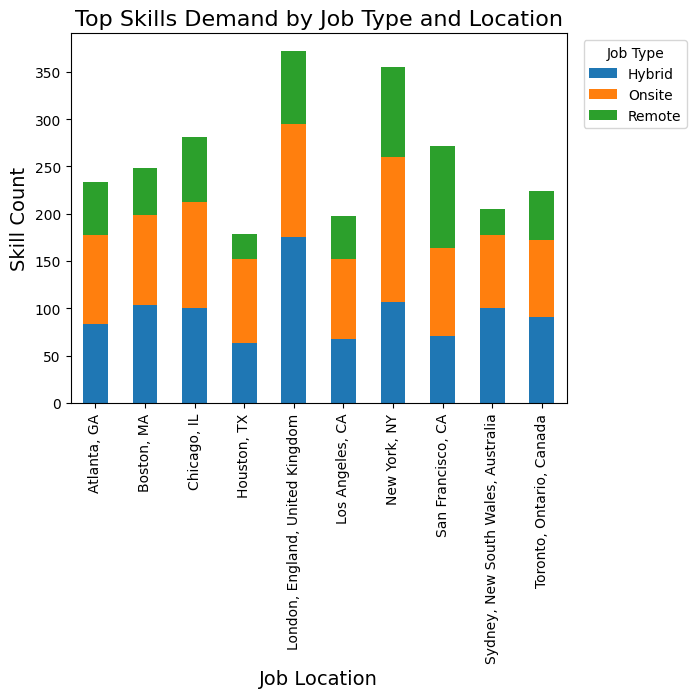

In [ ]:
top_locations = df_master['job_location'].value_counts().head(10).index

pivot_data = pd.pivot_table(df_master[df_master['job_location'].isin(top_locations)],
                             index='job_location',
                             columns='job_type',
                             values='token_number_after_lem',
                             aggfunc='count',
                             fill_value=0)


pivot_data = pivot_data.reset_index().sort_values(by='job_location')

plt.figure(figsize=(24, 6))
pivot_data.set_index('job_location')[sorted(pivot_data.columns[1:])].plot(kind='bar', stacked=True)
plt.title('Top Skills Demand by Job Type and Location', fontsize=16)
plt.xlabel('Job Location', fontsize=14)
plt.ylabel('Skill Count', fontsize=14)
plt.legend(title='Job Type', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.xticks(rotation=90)
plt.show()

**Visualization 4: Shahbaz Syed**
- The word cloud displayed visualizes the frequency of various skills demanded in the top five job categories.
- Prominent terms like 'Software Development,' 'AWS,' and 'Data Engineering' stand out, suggesting their critical importance in the job market.
- This offers a quick and intuitive way to understand the skill sets that are currently in high demand.

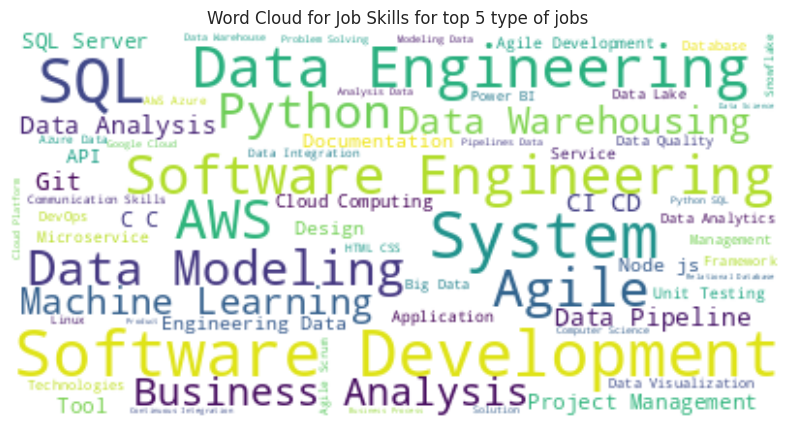

In [ ]:
from wordcloud import WordCloud

top_job_titles = df_master['job_title'].value_counts().index[:5]
df_top_jobs = df_master[df_master['job_title'].isin(top_job_titles)]

skills_string = " ".join(skill for skill in df_top_jobs['job_skills'])

wordcloud = WordCloud(background_color='white').generate(skills_string)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Job Skills for top 5 type of jobs')
plt.axis('off')
plt.show()

**Visualization 5: VVS Phani**
- The bar chart illustrates the distribution of job levels, comparing the prevalence of 'Associate' versus 'Mid Senior' level positions.
- The data shows a significantly higher count of 'Mid Senior' level jobs, highlighting a potential market trend favoring more experienced professionals.
- This insight could be critical for both job seekers and employers in understanding the current employment landscape.

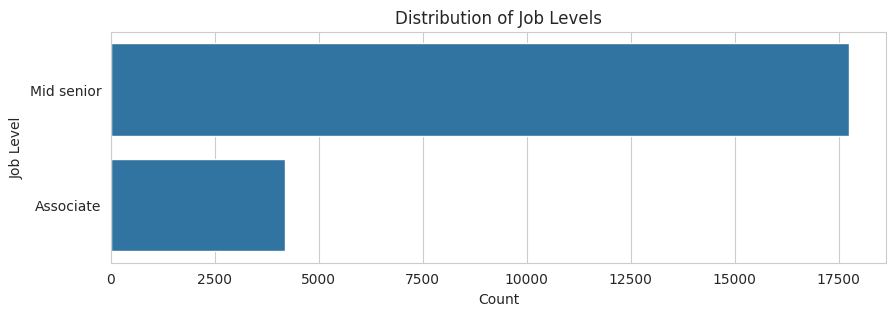

In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 3))
sns.countplot(y='job level', data=df_master, order = df_master['job level'].value_counts().index)
plt.title('Distribution of Job Levels')
plt.xlabel('Count')
plt.ylabel('Job Level')
plt.show()

**Visualization 6: VVS Phani**
- The word cloud depicted focuses on key skills relevant to the job market, with terms like 'data analysis,' 'machine learning,' 'project management,' and 'software development' being especially prominent.
- This suggests a high demand for these skills across various industries in general.
- The graphic serves as a visual guide for individuals looking to refine their expertise to align with market needs.

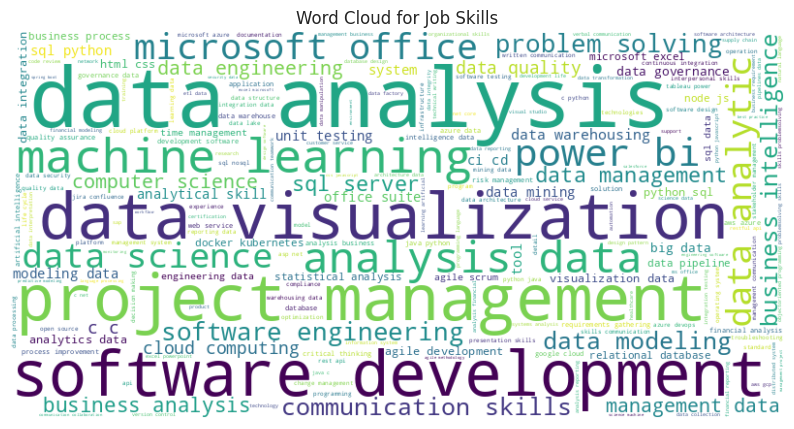

In [ ]:
skills_series = df_master['job_skills'].dropna().apply(lambda x: ' '.join(x.lower().split(',')))
all_skills = ' '.join(skills_series)
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(all_skills)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Job Skills')
plt.show()

**Visualization 7: VVS Phani**
- The heatmap visualizes a cross-tabulation of job levels against job types. - Mid-senior level roles dominate, especially in the onsite category, indicating a mature job market.
- Associate roles are fewer in comparison, with hybrid roles outnumbering remote opportunities at this level.
- This data could inform job seekers about the most prevalent job types at different career stages.

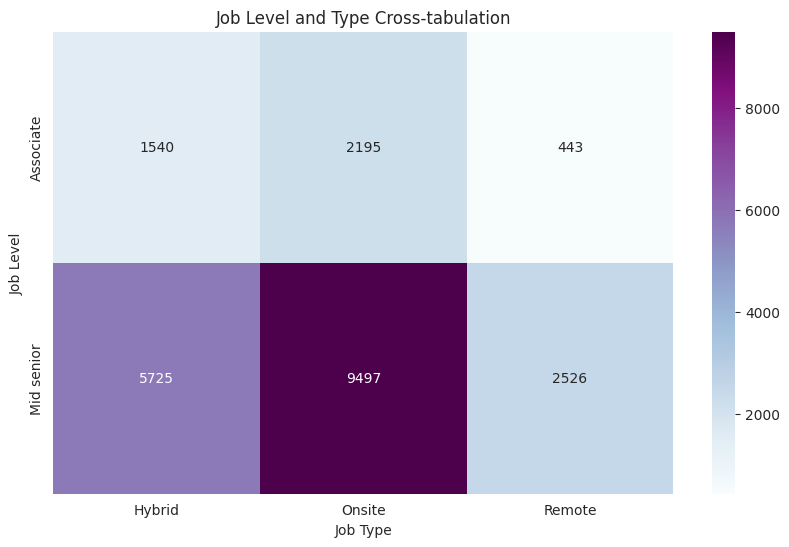

In [ ]:
plt.figure(figsize=(10, 6))
job_level_type_cross = pd.crosstab(df_master['job level'], df_master['job_type'])
sns.heatmap(job_level_type_cross, annot=True, fmt="d", cmap="BuPu")
plt.title('Job Level and Type Cross-tabulation')
plt.xlabel('Job Type')
plt.ylabel('Job Level')
plt.show()

*Dropping features that are not required now as they are redundant and other feature carry the inherent information they provide.*

In [ ]:
df_master.drop(['latitude_longitude', 'POS', 'POS_clean', 'clean_token', 'token_number', 'clean_job_desc', 'job_summary', 'latitude', 'longitude'],  axis=1, inplace=True)

In [ ]:
df_master.head(2)

job_title                        company  \
0  Market Research & Insights Analyst  Indiana University Foundation   
1         Business Systems Analyst `1                   Cook Medical   

      job_location                                           job_link  \
0  Bloomington, IN  https://www.linkedin.com/jobs/view/market-rese...   
1  Bloomington, IN  https://www.linkedin.com/jobs/view/business-sy...   

   search_city search_country   job level job_type  \
0  Bloomington  United States  Mid senior   Onsite   
1  Bloomington  United States  Mid senior   Onsite   

                                          job_skills         city  \
0  Data analysis, Market research, Survey develop...  Bloomington   
1  Business Analysis, Technical Writing, Software...  Bloomington   

                normalized_job_title  \
0  Market Research  Insights Analyst   
1         Business Systems Analyst 1   

                                  job_skills_summary  \
0   data analysis,  market research,  survey deve...   
1   business  analysis,  technical  writing,  sof...   

                                        job_desc_lem  token_number_after_lem  
0  data analysis market research survey developme...                     573  
1  business analysis technical writing software t...                     352

This gives us the spread of token across the data.
- Though outliers are present (Jobs with more than 800 tokens in job summary), we are not removing them or truncating as they can contain rich-information that can help the model.
- This may lead to sparsity but we are not concerned with that at this point in time.

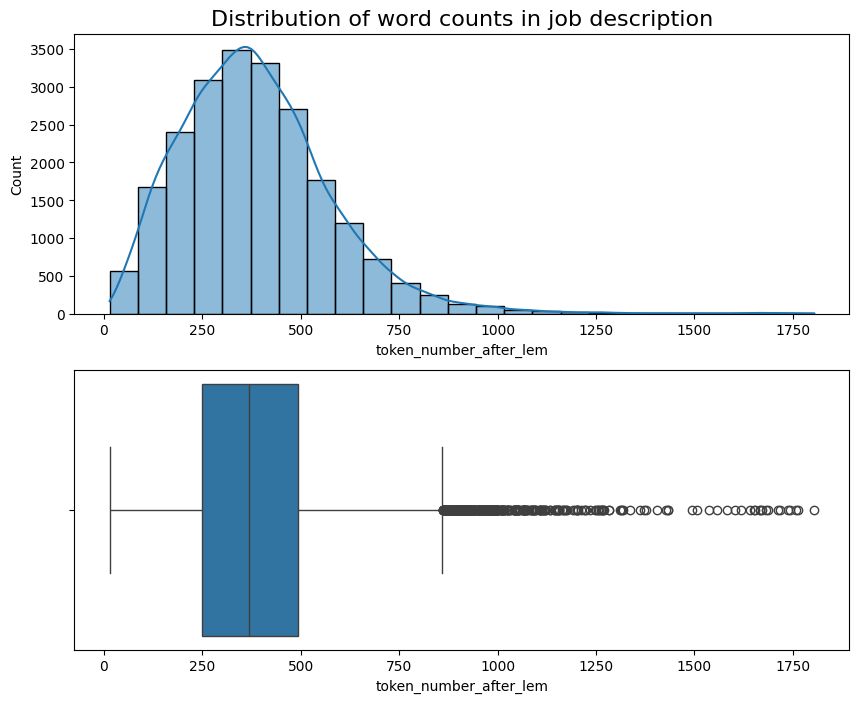

In [ ]:
from scipy.stats import normaltest

df_master["token_number_after_lem"].describe()
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

histplot = sns.histplot(
    data=df_master,
    x="token_number_after_lem",
    bins=25,
    kde=True,
    ax=axes[0]);
histplot.set_title("Distribution of word counts in job description",  fontsize=16);

boxplot = sns.boxplot(
    data=df_master,
    x="token_number_after_lem",
    orient="h",
    width=0.9,
    ax=axes[1]);



In [ ]:
from collections import Counter, defaultdict

df_master[df_master["token_number_after_lem"] > 800]['job_desc_lem'].count()

630

In [ ]:
# Not removing the jobs as outliers with more token. May contain important information needed.

In [ ]:
df_master["normalized_job_title"][5]

'Business Analyst'

In [ ]:
def normalize_skills(skill_string):

    return [skill.strip().lower() for skill in skill_string.split(',') if skill]

df_master['normalized_job_skills'] = df_master['job_skills'].apply(lambda x: normalize_skills(x))

def top_n_skills(skill_lists, n=10):
    aggregated_skills = Counter([skill for sublist in skill_lists for skill in sublist if skill])
    return aggregated_skills.most_common(n)

skill_counts_per_job_title = df_master.groupby('normalized_job_title')['normalized_job_skills'].agg(lambda x: top_n_skills(x, n=10)).reset_index(name='top_skills')
top_20_titles = df_master['normalized_job_title'].value_counts().head(20).index.tolist()

for title in top_20_titles:
    top_skills = skill_counts_per_job_title.loc[skill_counts_per_job_title['normalized_job_title'] == title, 'top_skills'].iloc[0]
    print(f"Top 10 skills for {title}: {top_skills}")

Top 10 skills for Senior Software Engineer: [('python', 796), ('java', 725), ('aws', 690), ('sql', 577), ('javascript', 510), ('agile', 489), ('docker', 402), ('go', 370), ('kubernetes', 369), ('typescript', 351)]
Top 10 skills for Software Engineer: [('python', 357), ('java', 282), ('javascript', 254), ('aws', 235), ('software engineering', 222), ('git', 210), ('c++', 208), ('sql', 203), ('c#', 194), ('react', 176)]
Top 10 skills for Business Analyst: [('business analysis', 296), ('project management', 197), ('data analysis', 164), ('communication', 129), ('requirements gathering', 108), ('agile', 103), ('sql', 101), ('excel', 84), ('jira', 74), ('communication skills', 70)]
Top 10 skills for Senior Data Engineer: [('python', 427), ('sql', 364), ('data engineering', 247), ('aws', 195), ('snowflake', 159), ('spark', 153), ('data modeling', 152), ('etl', 140), ('data warehousing', 137), ('java', 128)]
Top 10 skills for Data Engineer: [('python', 283), ('sql', 279), ('data engineering', 

**Visualization 8: Usha**
- The bar chart ranks the top 10 normalized job skills in frequency, with 'SQL' and 'Python' leading the chart, indicative of their high demand in the tech industry.
- Skills in 'data analysis' and 'java' are also prevalent, while 'communication' skills are emphasized as essential.
- This information is crucial for job seekers aiming to prioritize their learning and development focus areas.

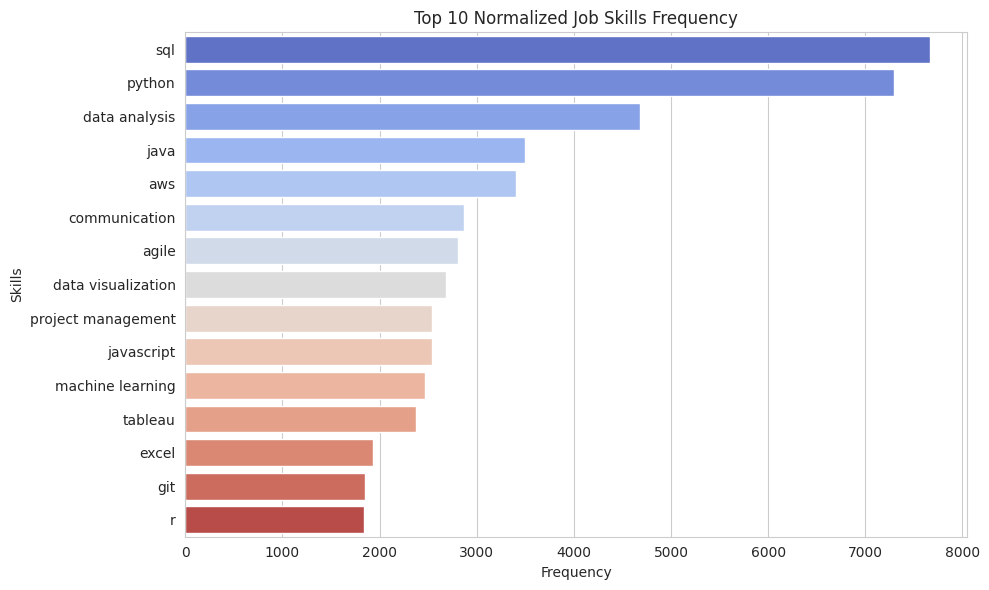

In [ ]:
sns.set_style("whitegrid")
all_skills_dict = {}
for skills_list in df_master['normalized_job_skills']:
    for skill in skills_list:
        if skill in all_skills_dict:
            all_skills_dict[skill] += 1
        else:
            all_skills_dict[skill] = 1


top_skills_dict = dict(sorted(all_skills_dict.items(), key=lambda item: item[1], reverse=True)[:15])


top_skills_df = pd.DataFrame(list(top_skills_dict.items()), columns=['Skill', 'Frequency'])

plt.figure(figsize=(10, 6))
sns.barplot(x='Frequency', y='Skill', data=top_skills_df, palette='coolwarm')
plt.title('Top 10 Normalized Job Skills Frequency')
plt.xlabel('Frequency')
plt.ylabel('Skills')
plt.tight_layout()

plt.show()

**Visualization 9: Saurav Joshi**


-  After having the final data ready, this visualization helps us know the most common skills required in jobs.
-   This can directly help a candidate to align themselves with these skills based on the job they are looking for.
- Also it can be seen as learning Python and SQL has the best advantage as it is present across job titles.



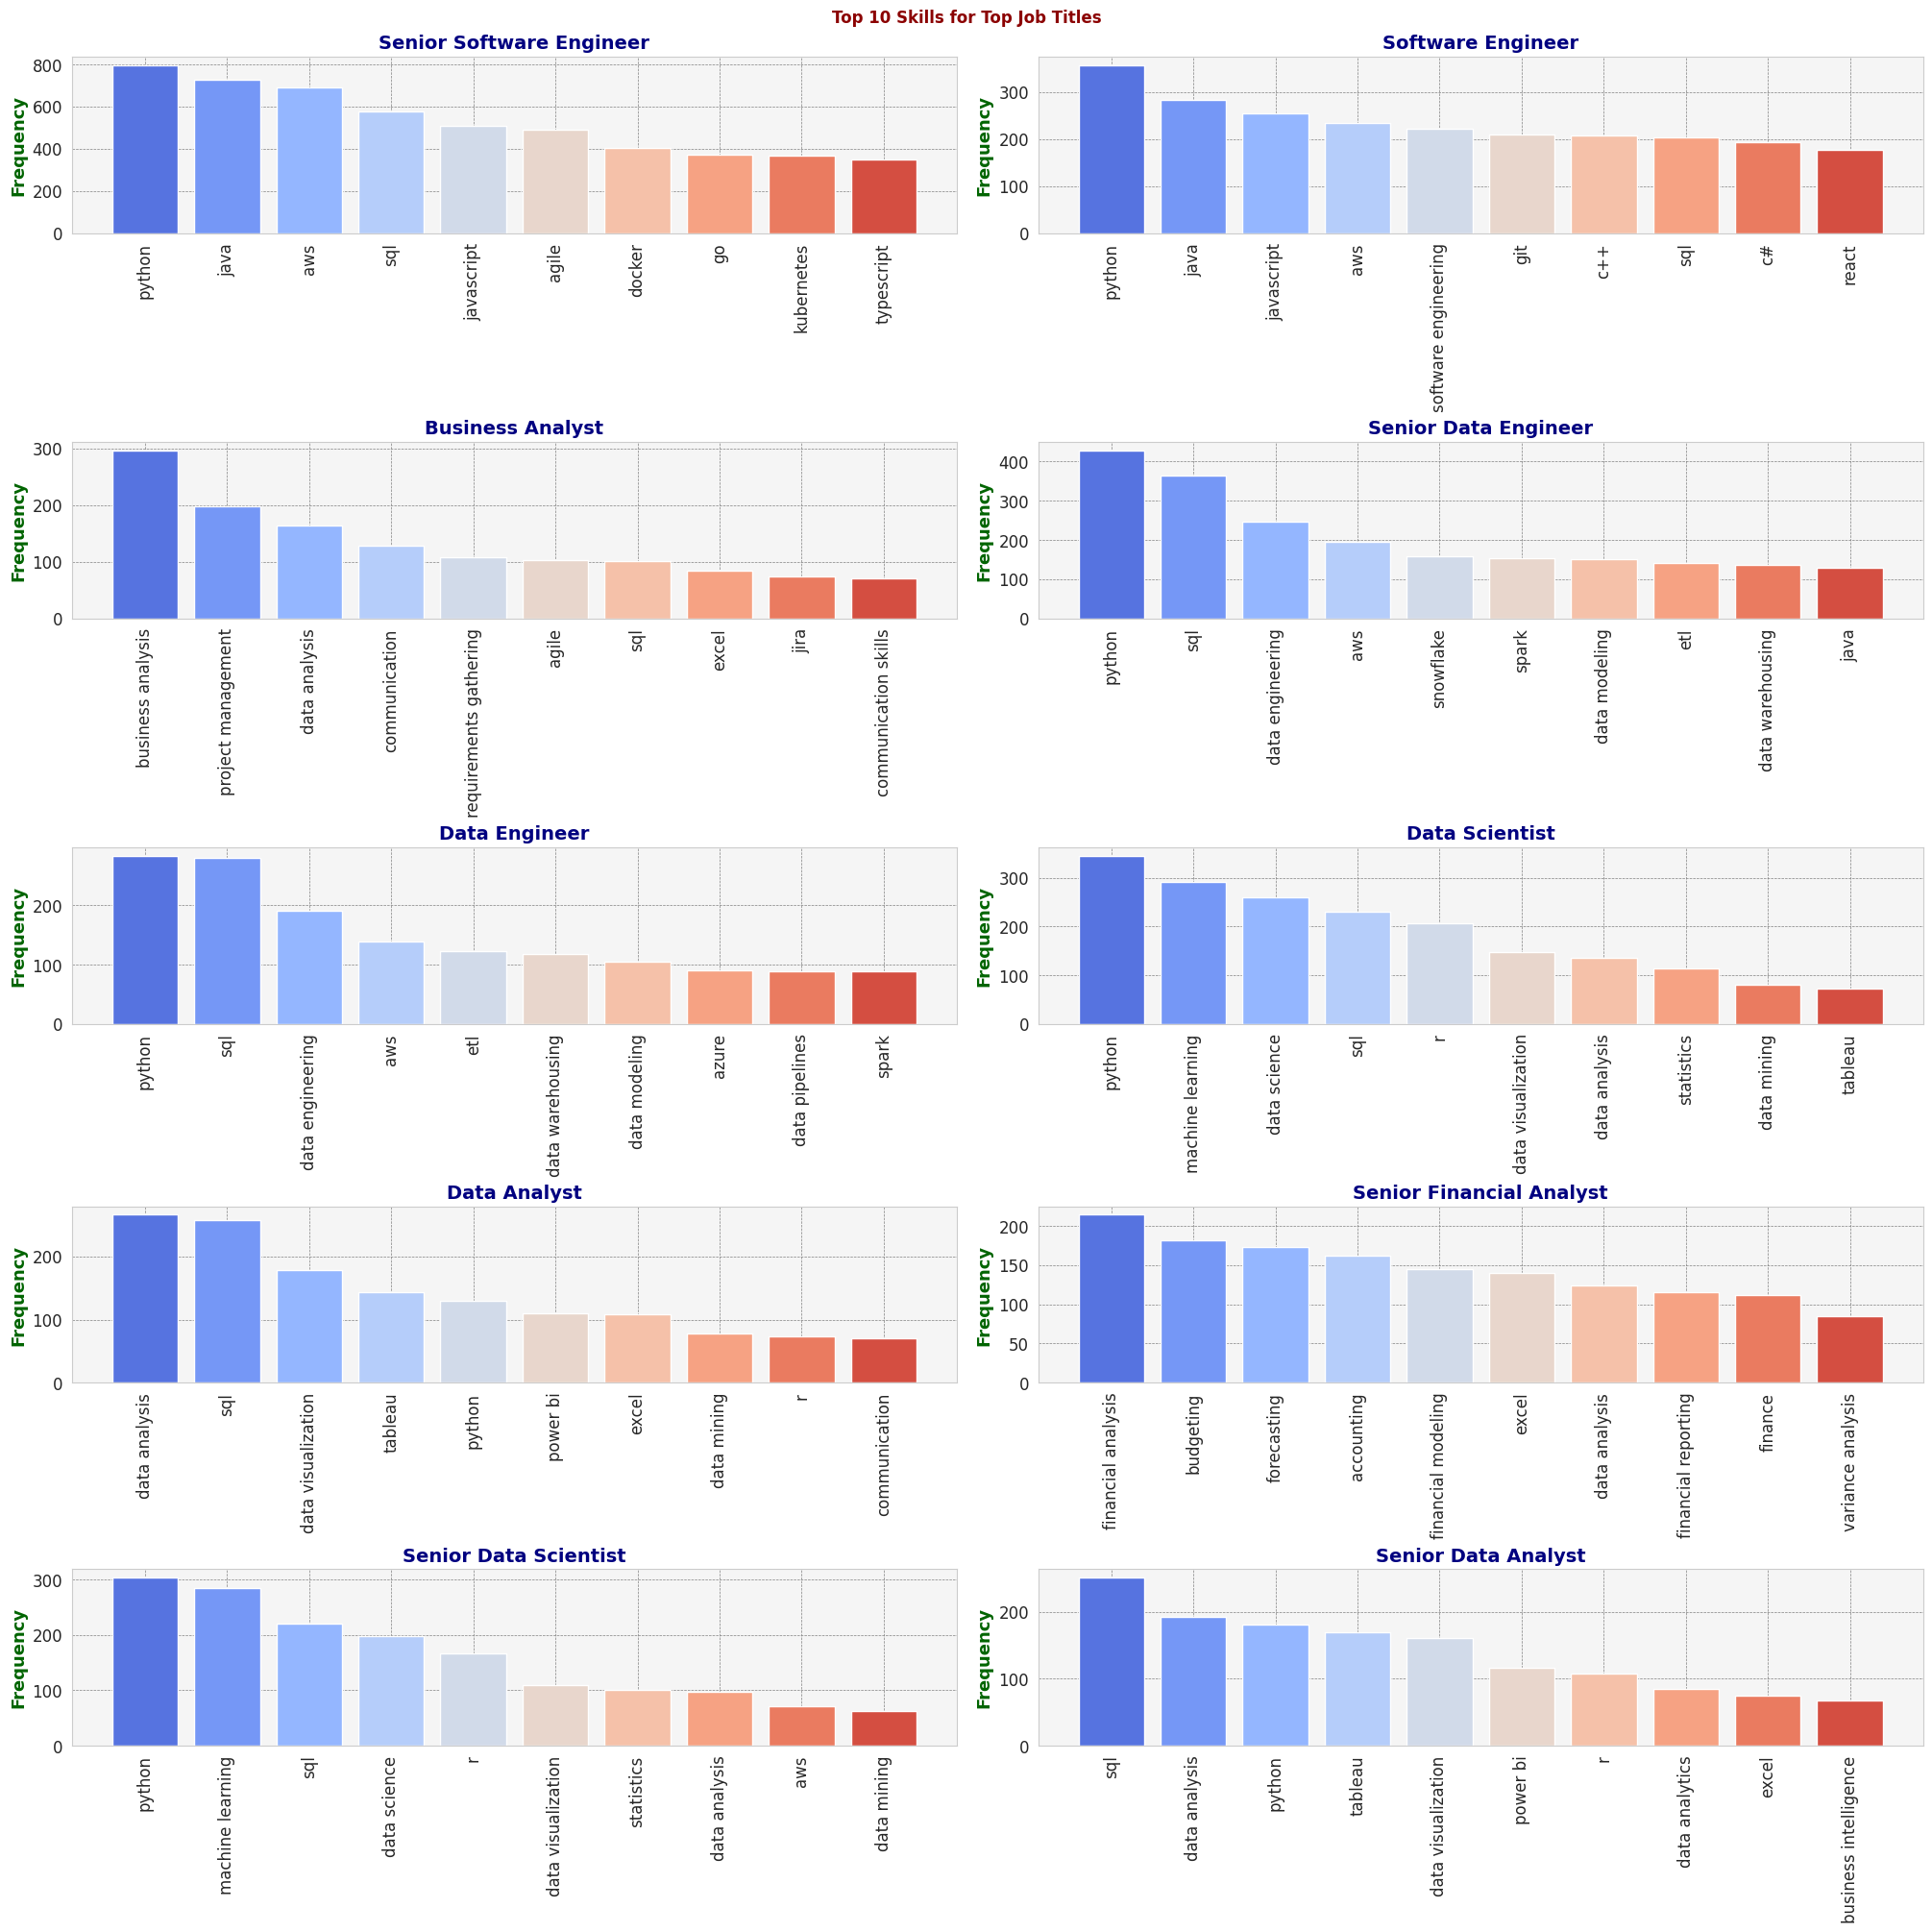

In [ ]:
sns.set_style("whitegrid")

ncols = 2
num_titles_to_plot = 10
nrows = num_titles_to_plot // ncols + (num_titles_to_plot % ncols > 0)
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 4 * nrows), constrained_layout=True)


palette = sns.color_palette("coolwarm", n_colors=10)
axs = axs.flatten()

for i, title in enumerate(top_20_titles[:num_titles_to_plot]):

    top_skills = skill_counts_per_job_title.loc[skill_counts_per_job_title['normalized_job_title'] == title, 'top_skills'].iloc[0]
    skills, counts = zip(*top_skills)


    axs[i].bar(skills, counts, color=palette)
    axs[i].set_title(title, fontsize=14, fontweight='bold', color='navy')
    axs[i].tick_params(axis='x', rotation=90, labelsize=12)
    axs[i].tick_params(axis='y', labelsize=12)
    axs[i].set_ylabel('Frequency', fontsize=13, fontweight='bold', color='darkgreen')


    axs[i].grid(True, which='major', linestyle='--', linewidth='0.5', color='grey')
    axs[i].set_facecolor('whitesmoke')

for i in range(len(top_20_titles[:num_titles_to_plot]), len(axs)):
    axs[i].axis('off')

plt.suptitle('Top 10 Skills for Top Job Titles', fontsize=12, fontweight='bold', color='darkred')
plt.show()


VISUALIZATION - 10 : Venkata Pidaparthi

Geographical Distribution of Remote vs Onsite Jobs

Purpose and Insight:
This map visually differentiates between remote, onsite, and hybrid jobs based on their locations, highlighting regional preferences or necessities for job types. It's a tool for understanding the job market's geographical nuances, offering insights for job seekers, companies, and analysts.

Uses:
- Helps job seekers find areas with a high density of preferred job types.
- Aids companies in identifying regions with the workforce they need.
- Provides market insights for strategic decisions and trend analysis.

In [ ]:
fig = px.scatter_mapbox(df_master, lat="latitude", lon="longitude", color="job_type",
                        hover_name="job_title", hover_data=["company", "job_location"],
                        color_discrete_map={"Remote": "green", "Onsite": "blue", "Hybrid": "purple"},
                        zoom=3, height=600, title="Geographical Distribution of Remote vs Onsite Jobs")
fig.update_layout(mapbox_style="open-street-map")
fig.show()


# Modelling

- Use **CountVectorizer** and **TfidfVectorizer** to convert text (processed job summary) into vectors.
- Using n-gram range from 1-2 for CountVectorizer as words like "machine learning" are relatively rich in information than machine and learning independently.
- Avoiding words that are over 95% and less than 5 in frequency.
- Getting cosine similarity for a sample resume and the vectors generated.

> Saurav Joshi




In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    processed_text = ' '.join(tokens)
    return processed_text

# Baseline model setup
count_vect = CountVectorizer(ngram_range=(1,2), min_df=5, max_df=0.95)
count_job_desc = count_vect.fit_transform(df_master["job_desc_lem"])

# TF-IDF model setup
tfidf_vect = TfidfVectorizer(min_df=5, max_df=0.95)
tfidf_job_desc = tfidf_vect.fit_transform(df_master["job_desc_lem"])



> A common function to process similarities based on tfidf or countVec
- It is interesting to note that CountVectorizer's top 5 jobs possess more similarity with the resume than TfidfVectorizer.
 - However, this is because of the way **TfidfVectorizer** calculates the numerical value for a given vector. It adjusts for the frequency of the word in the corpus of documents. This means that common words across all documents are given less weight, and unique words are given more weight.
- The **CountVectorizer** model may be overemphasizing the importance of frequent terms, which can artificially inflate the similarity score, even if those terms aren't particularly meaningful.
- Thus, a higher cosine similarity score does not always mean a better match in terms of relevancy.

In [ ]:
def jobs_to_resume(raw_resume_text, model_type='tfidf'):
    resume_text = preprocess_text(raw_resume_text)

    if model_type == 'tfidf':
        resume_vector = tfidf_vect.transform([resume_text])
        job_desc_vector = tfidf_job_desc
    else:
        resume_vector = count_vect.transform([resume_text])
        job_desc_vector = count_job_desc

    cosine_similarities = cosine_similarity(resume_vector, job_desc_vector).flatten()
    top_5_job_indices = cosine_similarities.argsort()[-5:][::-1]

    top_5_jobs = df_master.iloc[top_5_job_indices]
    job_indices = top_5_jobs.index

    return top_5_jobs, job_indices, cosine_similarities[top_5_job_indices], resume_vector

# This is for now. This shall be updated to a resume parser.
raw_parsed_resume_text = "Saul Joshi 347-466-8549 | sjoshi50@uic.edu | linkedin.com/in/sauravjoshi27 | github.com/sauravjoshi | sauravjoshi.dev Versatile Software Engineer: Transforming Ideas into Reality with 3+ Years in Web, Software & ML Innovation Backed by Published Research Education University of Illinois at Chicago (UIC) Masters of Science in Computer Science(GPA 4.0/4.0) Uttarakhand Technical University Bachelor of Technology in Computer Science(1st Div with Hons.) Chicago, IL Dec 2024 Dehradun, India Dec 2018 Technical Skills Languages: Modern C++, JavaScript, Python, SQL, Unix Shell Frameworks: Pytorch, Boost.Asio, NodeJS, Express, Typescript, Astro, Flask, Flask-RESTful, React Cloud and DevOps: AWS (EC2, Lambda, SQS, SNS, Sagemaker, Load Balancer, ASG, ECS), Docker, Kubernetes, Git, Linux Tools, Database, Performance & Unit Testing: LangChain, CMake, MySQL, MongoDB, PostgreSQL, SQL, Mocha, Vitest Recent Projects Enhancing Privacy in Medical Dialogue LLMs | Python, Pytorch, NLP, LLAMA-2, QLoRA Sept 2023 – Oct 2023 • Investigated privacy risks in medical dialogue LLMs by fine-tuning a 7B LLAMA-2 model with QLoRA, achieving a comprehensive understanding of data leakage and developing effective mitigation strategies. • Implemented differential privacy techniques to evaluate and minimize the risk of sensitive data exposure in LLM outputs, thereby significantly bolstering data confidentiality in healthcare applications. TCP-Chat | C++ 17, CMake, Linux, Boost, Networking, TCP/IP, Asynchronous Programming Sept 2023 – Oct 2023 • Created an abstraction layer for TCP communication with Boost.Asio, enabling multi-client-server asynchronous chats. • Employed modern C++ features (smart pointers, lambda functions, move semantics) to facilitate non-blocking broadcast communication in a chat application between clients and servers. Gain Plugin | C++, CMake, Linux, GDB, JUCE Framework, OOP(Object-Oriented Programming) Aug 2023 – Sept 2023 • Developed a VST3 audio plugin using modern C++ and the JUCE framework, enabling user-configurable gain control across any Digital Audio Workstation. • Ensured cross-platform compatibility of the plugin across Windows, macOS, and Linux by utilizing Projucer, demonstrating the project’s adaptability and wide user accessibility. Experience University of Illinois Jan 2023 – Present Graduate Research Assistant - BITS Networked Systems Laboratory Chicago, IL • Developed a web application to optimize Google Drive storage, using WebtreeMaps, React DataGrids, and document embedding analysis, which led to the identification and deletion of redundant files, thereby freeing up to 22% of drive space. • Spearheaded security research on ad-retargeting, vulnerabilities, and exploitation through identity entanglement, demonstrating how a user’s identity over the internet can be exploited using even 1st party cookies. • Orchestrated container deployment and scalable microservices creation, enabling prebid data to be scraped from multiple websites in parallel, with lower latency and resulting in a 30% performance boost. Indian Institute Of Technology Kharagpur Sep 2020 – July 2022 Software Engineer Kharagpur, India • Collaborated with Amazon Web Services (AWS) to transform nationwide AI e-learning accessibility via the AIShiksha platform, leading to a 15% surge in user traffic by scaling web services through a strategic overhaul from a monolithic architecture to efficient containerized microservices. • Led the backend development and AWS migration, utilizing Node.js, Python, MongoDB, and Sockets to ensure high availability and real-time user communication, thereby significantly enhancing platform adoption and performance. • Reduced operational costs by 65% by designing and implementing an automated user notification and idleness handler system, that efficiently managed Amazon Sagemaker notebooks, optimizing resource allocation and usage. Convin.AI Mar 2019 – Aug 2020 Machine Learning Engineer Bengaluru, India • Pioneered a Hindi Automated Speech Recognition Model, establishing a technology benchmark with the Kaldi Speech toolkit and deep learning techniques. This effort entailed extensive data collection, training, and fine-tuning, achieving high accuracy in Hindi speech processing. • The project’s significance was underscored by a publication in an IEEE conference, marking a significant advancement in speech recognition research and setting a new industry benchmark with a 10.6% Word Error Rate (WER).Publication & Achievements • Best paper award for a published article on Automatic Speech Recognition and NLP at IEEE’s 6th ICCCS conference - Las Vegas. • Conducted as part of the founding team of the AI startup and contributed to attaining more than 300,000 USD in funding. • Secured All India Rank 4 out of over 6000 teams in IEEE Xtreme worldwide coding competition. Courses & Certifications • LangChain for LLM Application Development by Deeplearning.ai. • Generative AI with Large Language Models by Coursera & Deeplearning.ai. • TensorFlow in Practice Specialization by Coursera & Deeplearning.ai. • Complete Guide to TensorFlow for Deep Learning from Udemy. • HIPAA - Group 2. HSP, Social / Behavioral Research Investigators and Key Personnel. • Parallel and Distributed Processing — Biomedical and Healthcare NLP — Secure web application development — Algorithms 401 — Computer System Security — High-Performance Processors and Systems — Database Systems"

recommended_jobs_tfidf, job_indices_tfidf, scores_tfidf, resume_vector_tfidf = jobs_to_resume(raw_parsed_resume_text, 'tfidf')

recommended_jobs_count, job_indices_count, scores_count,resume_vector_count = jobs_to_resume(raw_parsed_resume_text, 'count')

print("TF-IDF Model Recommendations:")
for job_idx, score in zip(job_indices_tfidf, scores_tfidf):
    print(f"Job Index: {job_idx}, Score: {score:.4f}")
    print(f"Job Description: {df_master.loc[job_idx, 'job_desc_lem']}")
    print("-----")

print("\nCount Vectorizer Model Recommendations:")
for job_idx, score in zip(job_indices_count, scores_count):
    print(f"Job Index: {job_idx}, Score: {score:.4f}")
    print(f"Job Description: {df_master.loc[job_idx, 'job_desc_lem']}")
    print("-----")



TF-IDF Model Recommendations:
Job Index: 19972, Score: 0.2335
Job Description: ai data science team leadership nlp computer vision ml python pytorch tensorflow currently partnered exciting well funded fintech start greater san diego area looking expand data science team responsibility lead team ai scientist provide guidance support advance methodology model building design accurate scalable design architecture align business objective participate development implementation ai model utilizing nlp computer vision develop design ai ml model inception qualification advanced degree physic mathematics experience managing small data science team deep understanding programming language python deep understanding deep learning framework pytorch tensorflow hand experience finetuning llm show show le
-----
Job Index: 18653, Score: 0.2250
Job Description: data science machine learning artificial intelligence natural language processing audio signal processing video signal processing speech processi

In [ ]:
recommended_jobs_count.head(3)

job_title                company job_location  \
19904  Data Scientist, Senior Analyst  University of Chicago  Chicago, IL   
19906              Sr. Data Scientist  University of Chicago  Chicago, IL   
17184              Software Developer         Project Canary   Denver, CO   

                                                job_link search_city  \
19904  https://www.linkedin.com/jobs/view/data-scient...     Chicago   
19906  https://www.linkedin.com/jobs/view/sr-data-sci...     Chicago   
17184  https://www.linkedin.com/jobs/view/software-de...     Boulder   

      search_country   job level job_type  \
19904  United States  Mid senior   Onsite   
19906  United States  Mid senior   Onsite   
17184  United States  Mid senior   Onsite   

                                              job_skills     city  \
19904  Programming, Data science, Engineering, Scalab...  Chicago   
19906  Data science, Machine learning, Natural langua...  Chicago   
17184  Full Stack Development, Web Development, Softw...   Denver   

        normalized_job_title  \
19904         Data Scientist   
19906  Senior Data Scientist   
17184     Software Developer   

                                      job_skills_summary  \
19904   programming,  data science,  engineering,  sc...   
19906   data science,  machine learning,  natural lan...   
17184   full  stack  development,  web  development, ...   

                                            job_desc_lem  \
19904  programming data science engineering scalable ...   
19906  data science machine learning natural language...   
17184  full stack development web development softwar...   

       token_number_after_lem  \
19904                     762   
19906                     702   
17184                     373   

                                   normalized_job_skills  
19904  [programming, data science, engineering, scala...  
19906  [data science, machine learning, natural langu...  
17184  [full stack development, web development, soft...

Next we employ a KNN-based recommender system to match job descriptions with a candidate's resume.
- Unlike relying solely on term frequency metrics from `CountVectorizer` or `TfidfVectorizer`, our KNN approach captures the nuanced similarities within the feature space.
- This method enhances the recommendation quality by considering a wider context and providing more personalized job matches.
- It proves advantageous as it factors in the multidimensional relationship between data points, offering a sophisticated alternative to simple similarity scoring.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

def get_recommendations(model, job_desc_matrix, resume_vector, n_neighbors=5):

    model.fit(job_desc_matrix)

    distances, indices = model.kneighbors(resume_vector, n_neighbors=n_neighbors)

    recommendations = []
    for dist, idx in zip(distances[0], indices[0]):
        job_info = df_master.iloc[idx].to_dict()
        job_info['Match Distance'] = dist
        recommendations.append(job_info)
    return pd.DataFrame(recommendations)

knn = NearestNeighbors(n_neighbors=5, metric='cosine')

count_recommendations = get_recommendations(knn, count_job_desc, resume_vector_count, n_neighbors=5)
tfidf_recommendations = get_recommendations(knn, tfidf_job_desc, resume_vector_tfidf, n_neighbors=5)



- It is intersting to note that the Match distance for CountVectorizer base recommendations is low in comparison with TfidfVectorizer which clearly illustrated the shortcoming of TfIdf punishing resume description keywords occurence across the corpus.
- We thus aim to move towards more contextually rich embedddings word2vec, glove, or use state-of-the-art open source Embedding models or APIs.

In [ ]:
import plotly.graph_objects as go


x_tfidf = [0] * len(tfidf_recommendations['Match Distance'])
x_count = [1] * len(count_recommendations['Match Distance'])


fig = go.Figure()

fig.add_trace(go.Scatter(
    x=x_tfidf,
    y=tfidf_recommendations['Match Distance'],
    mode='markers',
    name='TF-IDF',
    marker=dict(color='skyblue', size=12, line=dict(color='black', width=1)),
    text=tfidf_recommendations['job_title'],
    hoverinfo='text+y'
))

fig.add_trace(go.Scatter(
    x=x_count,
    y=count_recommendations['Match Distance'],
    mode='markers',
    name='Count Vectorizer',
    marker=dict(color='lightgreen', size=12, line=dict(color='black', width=1)),
    text=count_recommendations['job_title'],
    hoverinfo='text+y'
))

fig.update_layout(
    title='Detailed Job Recommendations Comparison',
    xaxis=dict(
        tickmode='array',
        tickvals=[0, 1],
        ticktext=['TF-IDF', 'Count Vectorizer']
    ),
    yaxis_title="Match Distance",
    margin=dict(l=20, r=20, t=30, b=20)
)

fig.show()


**Visualization 11: Saurav Joshi**


-  Trying to visualize how the recommended jobs are closer to resume in reduced dimensionality space (from original tfidf vector [21926 X 18017] ).
- Leverage T-SNE for two-dimensional t-SNE space.
- The cluster of blue dots near the 'X' suggests that the top recommendations are indeed closely aligned with the resume's features.



In [ ]:
tfidf_job_desc.shape

(21926, 18017)

In [ ]:
from sklearn.manifold import TSNE

# Use t-SNE to reduce the tf-idf vectors to two dimensions
tsne = TSNE(n_components=2, random_state=42)
tfidf_reduced_tsne = tsne.fit_transform(tfidf_job_desc.toarray())


In [ ]:
combined_tfidf = np.vstack((tfidf_job_desc.toarray(), resume_vector_tfidf.toarray()))
combined_reduced_tsne = tsne.fit_transform(combined_tfidf)

resume_reduced_tsne = combined_reduced_tsne[-1]
top_jobs_reduced_tsne = combined_reduced_tsne[job_indices_tfidf]

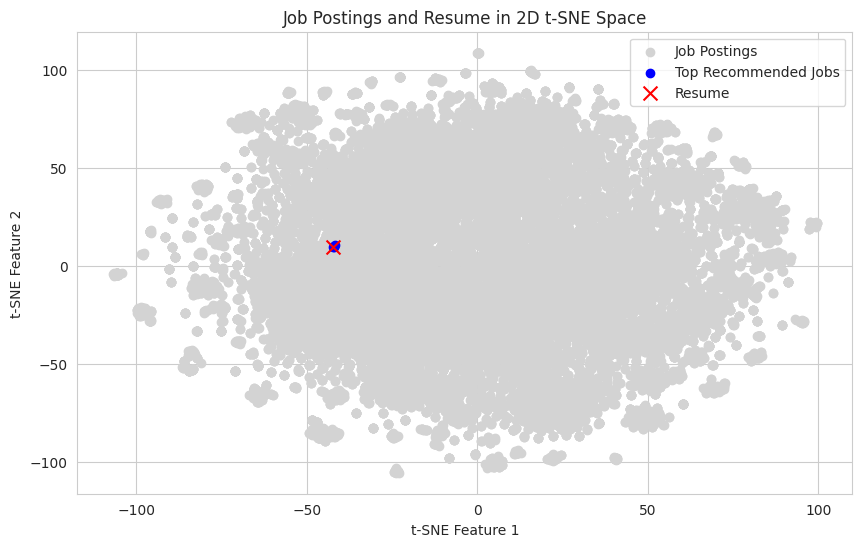

In [ ]:
plt.figure(figsize=(10, 6))

plt.scatter(tfidf_reduced_tsne[:, 0], tfidf_reduced_tsne[:, 1], c='lightgray', label='Job Postings')
plt.scatter(top_jobs_reduced_tsne[:, 0], top_jobs_reduced_tsne[:, 1], c='blue', label='Top Recommended Jobs')
plt.scatter(resume_reduced_tsne[0], resume_reduced_tsne[1], c='red', marker='x', s=100, label='Resume')

plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.title('Job Postings and Resume in 2D t-SNE Space')
plt.legend()
plt.show()

**Measurements**


1.  Creating 2 ground truth for the resume.
 - Job Titles relevant to the resume
 - Job Skills relevant to the resume
2.  Finally looking into the recommended jobs based on both Count and TF-IDF vector to check similarity with the ground truth labels.



In [ ]:
# Measuring How good the recommendations are.
# Using fuzzy matching instead of direct equivalent keyword matching.
!pip install fuzzywuzzy

In [ ]:
from fuzzywuzzy import fuzz

base_job_titles = ['Data Scientist', 'Machine Learning Engineer', 'Software Engineer']
base_skills = ['Python', 'Machine Learning', 'Deep Learning', 'C++', 'Node.JS', 'JavaScript', 'MongoDB']

def count_relevant_titles(recommendations, base_titles):
    count = 0
    for title in recommendations['normalized_job_title']:
        if any(fuzz.partial_ratio(title.lower(), ref.lower()) > 80 for ref in base_titles):
            count += 1
    return count

def count_relevant_skills(recommendations, base_skills):
    count = 0
    for skills in recommendations['normalized_job_skills']:
        individual_skills = skills
        for skill in individual_skills:
            if any(fuzz.partial_ratio(skill.strip().lower(), ref.lower()) > 90 for ref in base_skills):
                count += 1
                break
    return count


relevant_titles_tfidf = count_relevant_titles(tfidf_recommendations, base_job_titles)
relevant_titles_count = count_relevant_titles(count_recommendations, base_job_titles)

relevant_skills_tfidf = count_relevant_skills(tfidf_recommendations, base_skills)
relevant_skills_count = count_relevant_skills(count_recommendations, base_skills)

print("TF-IDF Recommendations:")
print(f"Relevant Titles: {relevant_titles_tfidf} / {len(tfidf_recommendations)}")
print(f"Relevant Skills: {relevant_skills_tfidf} / {len(tfidf_recommendations)}")

print("\nCount Vectorizer Recommendations:")
print(f"Relevant Titles: {relevant_titles_count} / {len(count_recommendations)}")
print(f"Relevant Skills: {relevant_skills_count} / {len(count_recommendations)}")


TF-IDF Recommendations:
Relevant Titles: 5 / 5
Relevant Skills: 5 / 5

Count Vectorizer Recommendations:
Relevant Titles: 4 / 5
Relevant Skills: 5 / 5


## Project Reflection

### Challenges Encountered
- **Data Procurement and Processing**: Securing appropriate data, particularly managing and deriving insights from textual content, alongside the complexities of modeling based on this data.

### Initial Insights
- **Model Performance**: The existing model is adept at providing job recommendations, with plans to further explore and utilize advanced embedding techniques for future model iterations.

### Concrete Results
- **Relevancy of Recommendations**: The model's job recommendations align closely with the baseline resume, showcasing the practical effectiveness of the current system.

### Future Hurdles
- **Enhanced Embeddings**: The primary focus is now on incorporating embeddings that capture richer contextual information to refine the recommendation process further.

### Project Trajectory
- **On Track**: The project is progressing as planned, aligning with the goals and deliverables outlined during the initial pitch presentation.

### Forward Strategy
- **Viability and Advancements**: The positive outcomes justify the project's continuation, with an immediate strategy to adopt state-of-the-art embedding models to improve the system's recommendation capabilities.


## Next Steps:


1.  We will be building dynamic web-application that takes in your resume, stores it in your machine (keeping your sensistive data to you).
2.  Using Clustering and KNN interpolated to recommend top-K relevant jobs amongst the most fit cluster.
3.  Moving to advanced embedding techniques as discussed above.



